# Phonon Band Structure Data Analysis for Thesis

The following notebook contains:

* Module Installations (Installed directly via pip, not a virtualenv) 
* Generation of a dataframe from Output files made in bash within subdirectories
* 2D Plots for EDIFF and EDIFFG analysing lattice constants and run time
* Non interactive 3D Plots made in matplotlib analysing lattice constants and run time
* Interactive 3D Plots made in plotly and exported in html analysing lattice constants and run time
* Annotated heatmap made in plotly, analysing negative frequencies
* TODO: Histogram of Inputs that result in Neg Freqs
* TODO: Find the mean of each parameters run time and tabulate it. Eg PBE vs PBEsol mean. 

In [1]:
!pip install pip install plotly==4.9.0
!pip install pip install chart_studio
!pip install -U kaleido

'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


Requirement already up-to-date: kaleido in c:\users\cameron\anaconda3\lib\site-packages (0.0.3.post1)


'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.interpolate as interp
import time
import matplotlib.ticker as tkr
import datetime

import sys
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly as plty
import plotly.express as px
import plotly.figure_factory as ff

plty.offline.init_notebook_mode(connected=True)

### The following cell parses through our generated output files for data, storing it in a pandas dataframe.

In [3]:
# Generating a df starting on indexed row 0
Reltime = pd.DataFrame(columns=['ENCUT','POT','EDIFF','EDIFFG', 'Relaxation Time', 'Phonopy Time','a','b','c'])
index = 0 

# Initialising lists
ENCUT_list = [500,800] 
POT_list = ["PBE","PBEsol"] 
EDIFF_list = [4,6,8,10,12]
EDIFFG_list = [2,4,6,8]

# Grabbing data and storing in a df

for POT in POT_list:
    
    for ENCUT in ENCUT_list:
        
        for EDIFFG in EDIFFG_list: 
            
            for EDIFF in EDIFF_list: 
            
                #print("\nENCUT:", str(ENCUT), "\nPOT:", POT, "\nEDIFF:", str(EDIFF), "\nEDIFFG:", str(EDIFFG))
                
                # Because I forgot to label the ENCUT file properly
                if ENCUT == 500:
                    ENCUTname = ""
                elif ENCUT == 800: 
                    ENCUTname = "_"+str(ENCUT)+"eV"
                   
                # Builds filename 
                relfile = "CsSnI3_"+str(POT)+str(ENCUTname)+"/"+"EDIFF_"+str(EDIFF)+"_EDIFFG_"+str(EDIFFG)+"/Cs"+str(POT)+"RELTIME_EDIFF_"+str(EDIFF)+"_EDIFFG_"+str(EDIFFG)+'.txt'
                
                try: 
                    with open(relfile , 'r') as dt:
                        for line in dt:
                            if "real" in line:
                                # Removes everything before the number
                                runtime = line[5:]
                                # LHS of 'm'
                                mins = float(runtime.split('m')[0])
                                # RHS of 'm' and removes 's' with :-2
                                secs = float(runtime.split('m')[1][:-2])
                                #print('\nRelaxaion time is', mins, 'mins and', secs, 'seconds.')
                                relaxation_time = mins*60 + secs 
                                #print('Total relaxation time is:', relaxation_time, 's')

                    # Builds filename         
                    phononfile = "CsSnI3_"+str(POT)+str(ENCUTname)+"/"+"EDIFF_"+str(EDIFF)+"_EDIFFG_"+str(EDIFFG)+"/Cs"+str(POT)+"PHONOPYTIME_EDIFF_"+str(EDIFF)+"_EDIFFG_"+str(EDIFFG)+'.txt'

                    with open(phononfile , 'r') as dt:
                        for line in dt:
                            if "real" in line:
                                # Removes everything before the number
                                runtime = line[5:]
                                # LHS of 'm'
                                mins = float(runtime.split('m')[0])
                                # RHS of 'm' and removes 's' with :-2
                                secs = float(runtime.split('m')[1][:-2])
                                #print('\nPhonopy time is', mins, 'mins and', secs, 'seconds.')
                                phonopy_time = mins*60 + secs 
                                #print('Total relaxation time is:', Phonopy Time, 's')
 
                    # Builds filename         
                    phononfile = "CsSnI3_"+str(POT)+str(ENCUTname)+"/"+"EDIFF_"+str(EDIFF)+"_EDIFFG_"+str(EDIFFG)+"/CONTCAR_"+str(POT)+"_EDIFF_"+str(EDIFF)+"_EDIFFG_"+str(EDIFFG)

                    with open(phononfile , 'r') as dt:
                        linenum = 0 
                        for line in dt:
                            if linenum == 2 :
                                a = float(line.split()[0])
                            if linenum == 3 :
                                b = float(line.split()[1])
                            if linenum == 4 :
                                c = float(line.split()[2])
                            linenum += 1
              
             
                    # Adds row to dataframe
                    Reltime.loc[index] = [ENCUT,POT,EDIFF,EDIFFG,relaxation_time,phonopy_time,a,b,c]
                    index += 1 
                
                # Due to incomplete dataset
                except FileNotFoundError:
                    pass          

### The following cells generate 2D line plots in the following order: 

* EDIFF Lattice Paramters 
* EDIFF Run Times
* EDIFFG Lattice Parameters
* EDIFFG Run Times

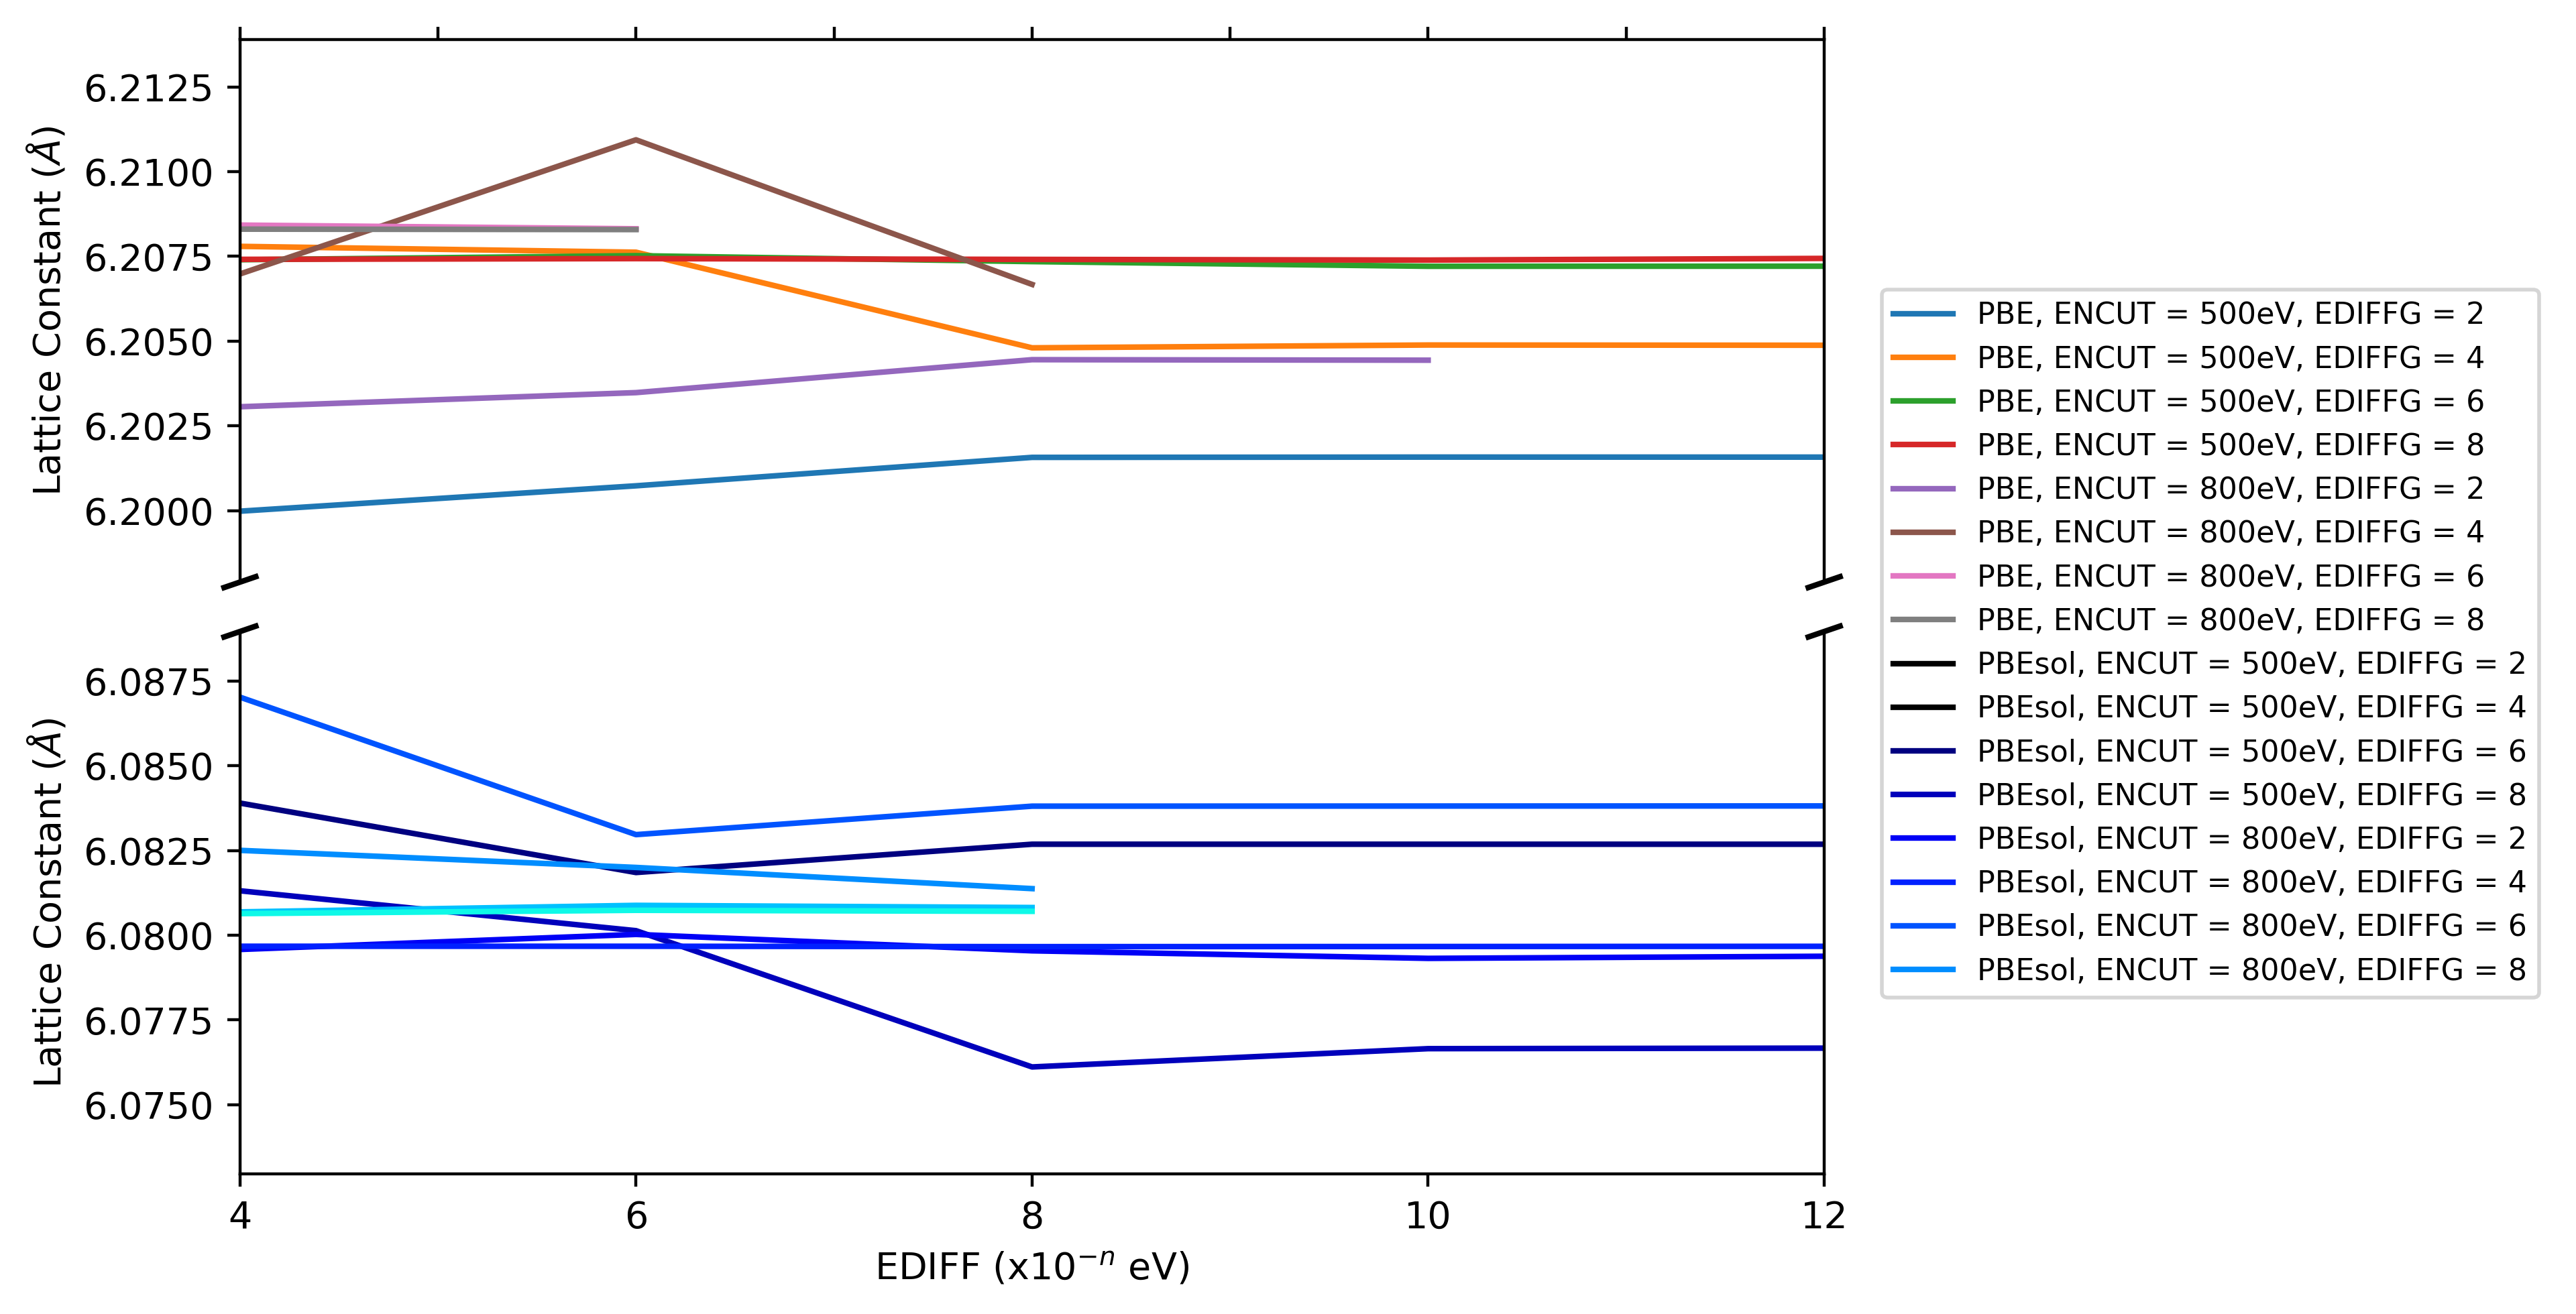

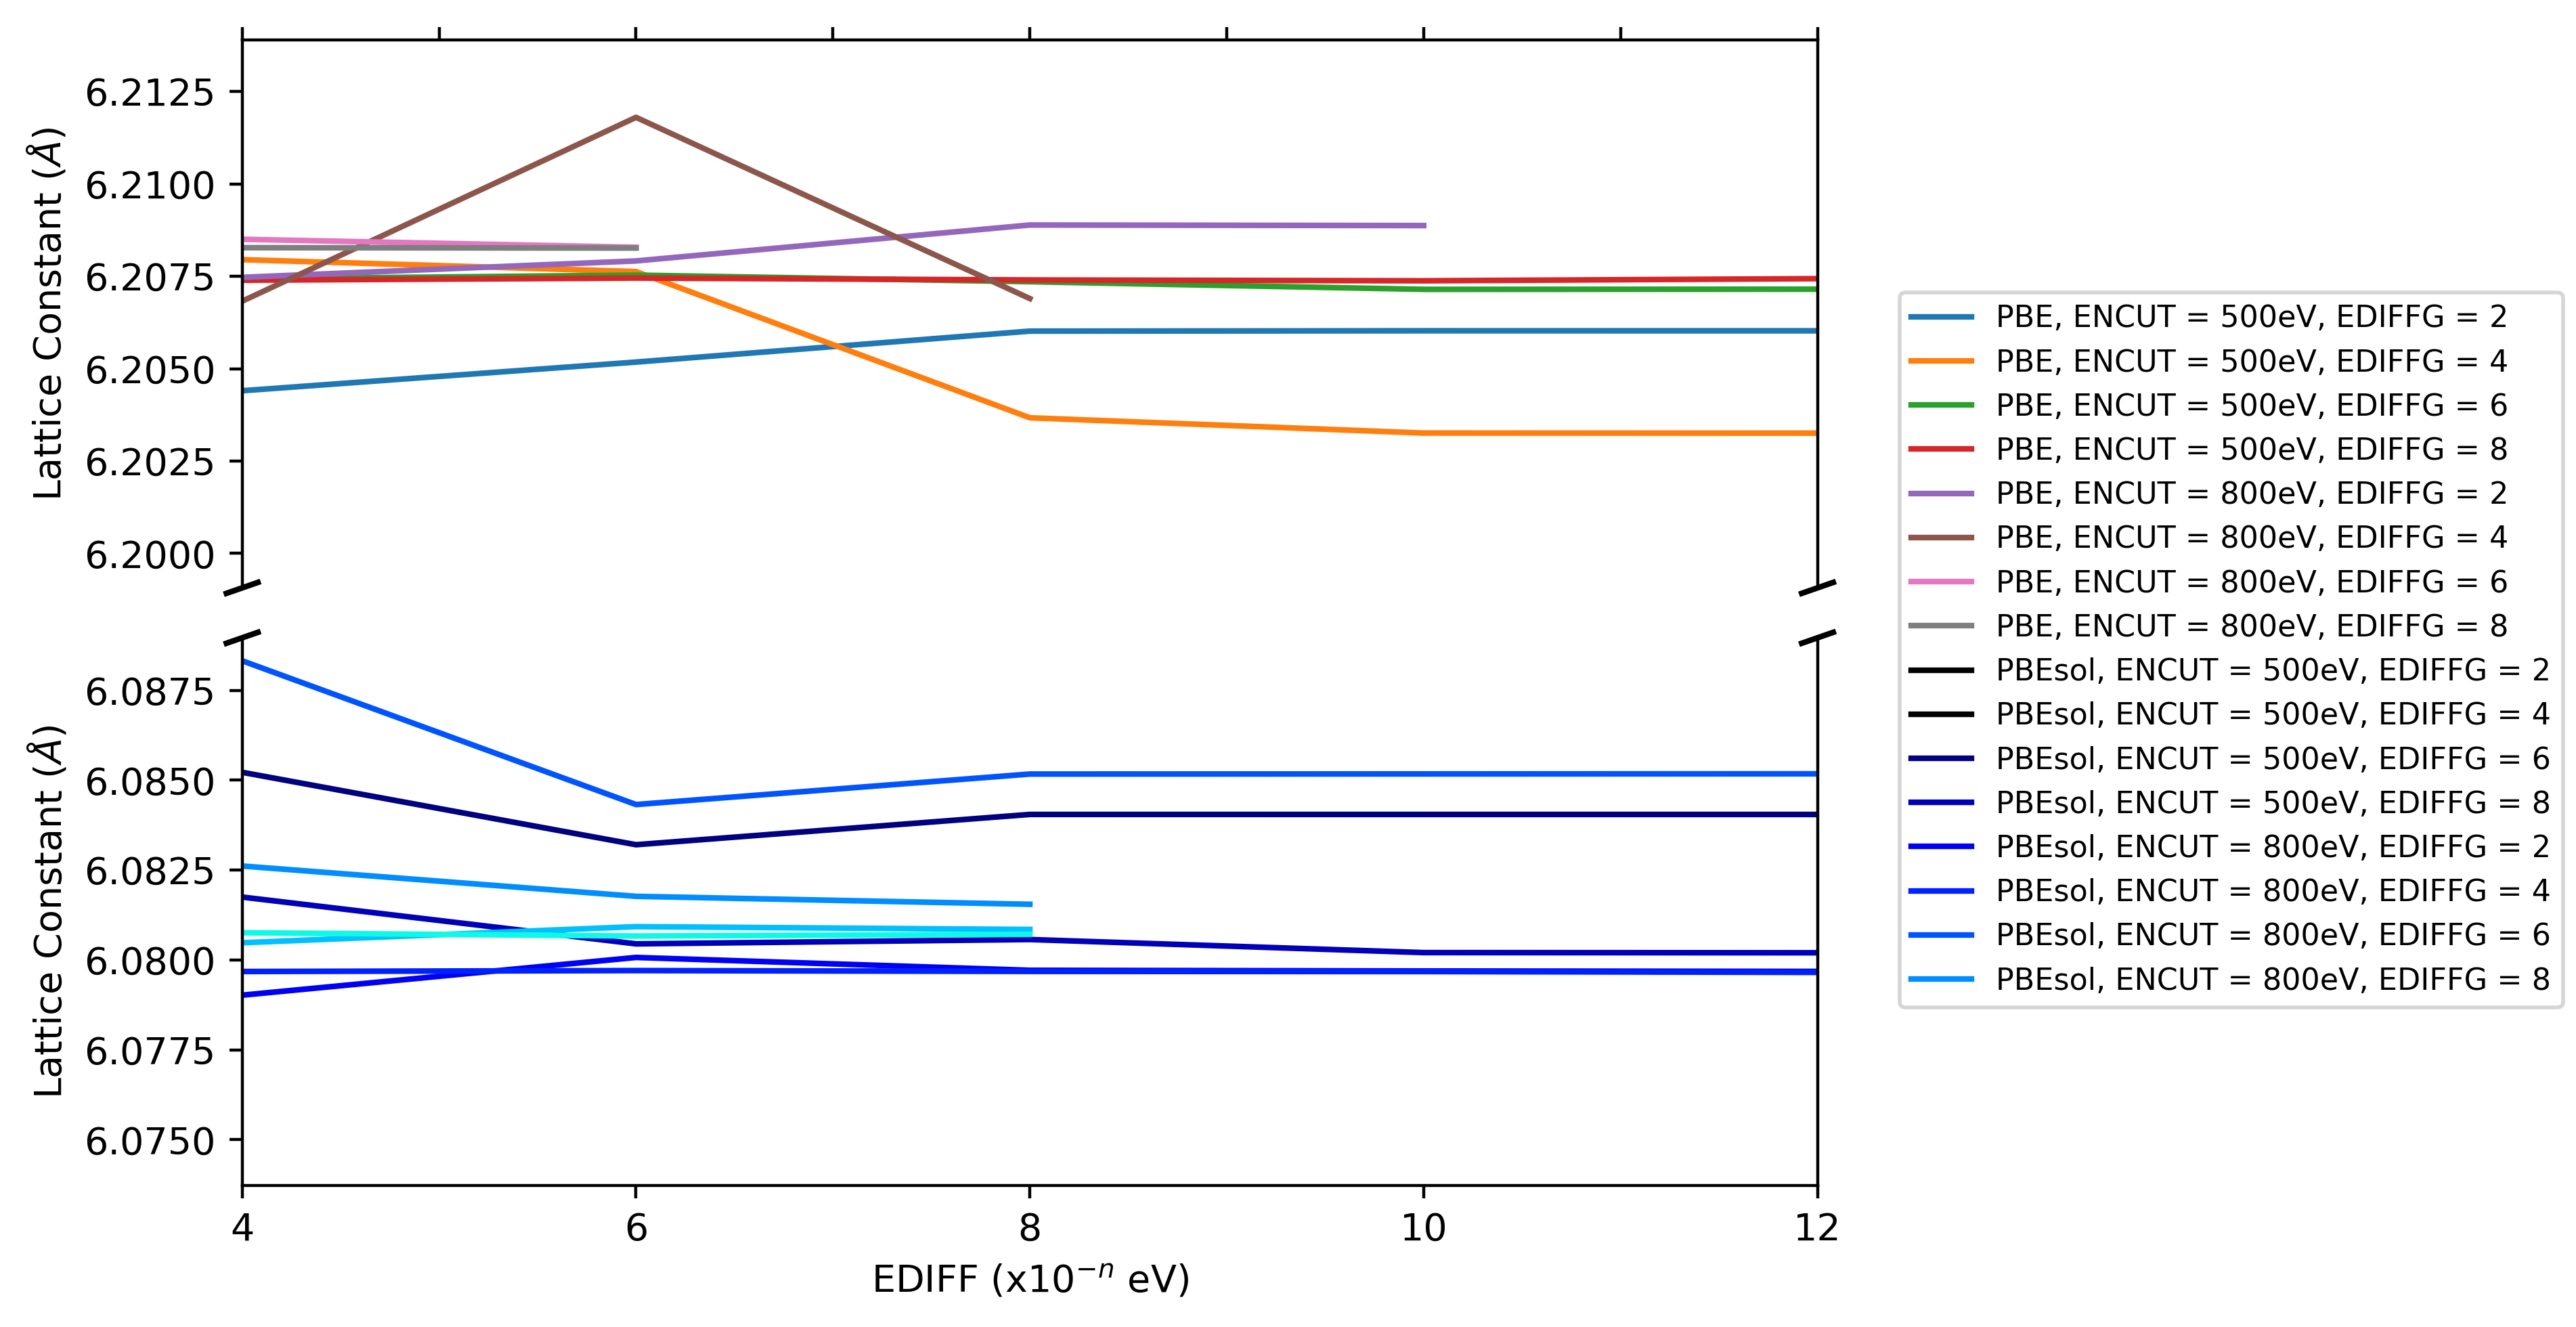

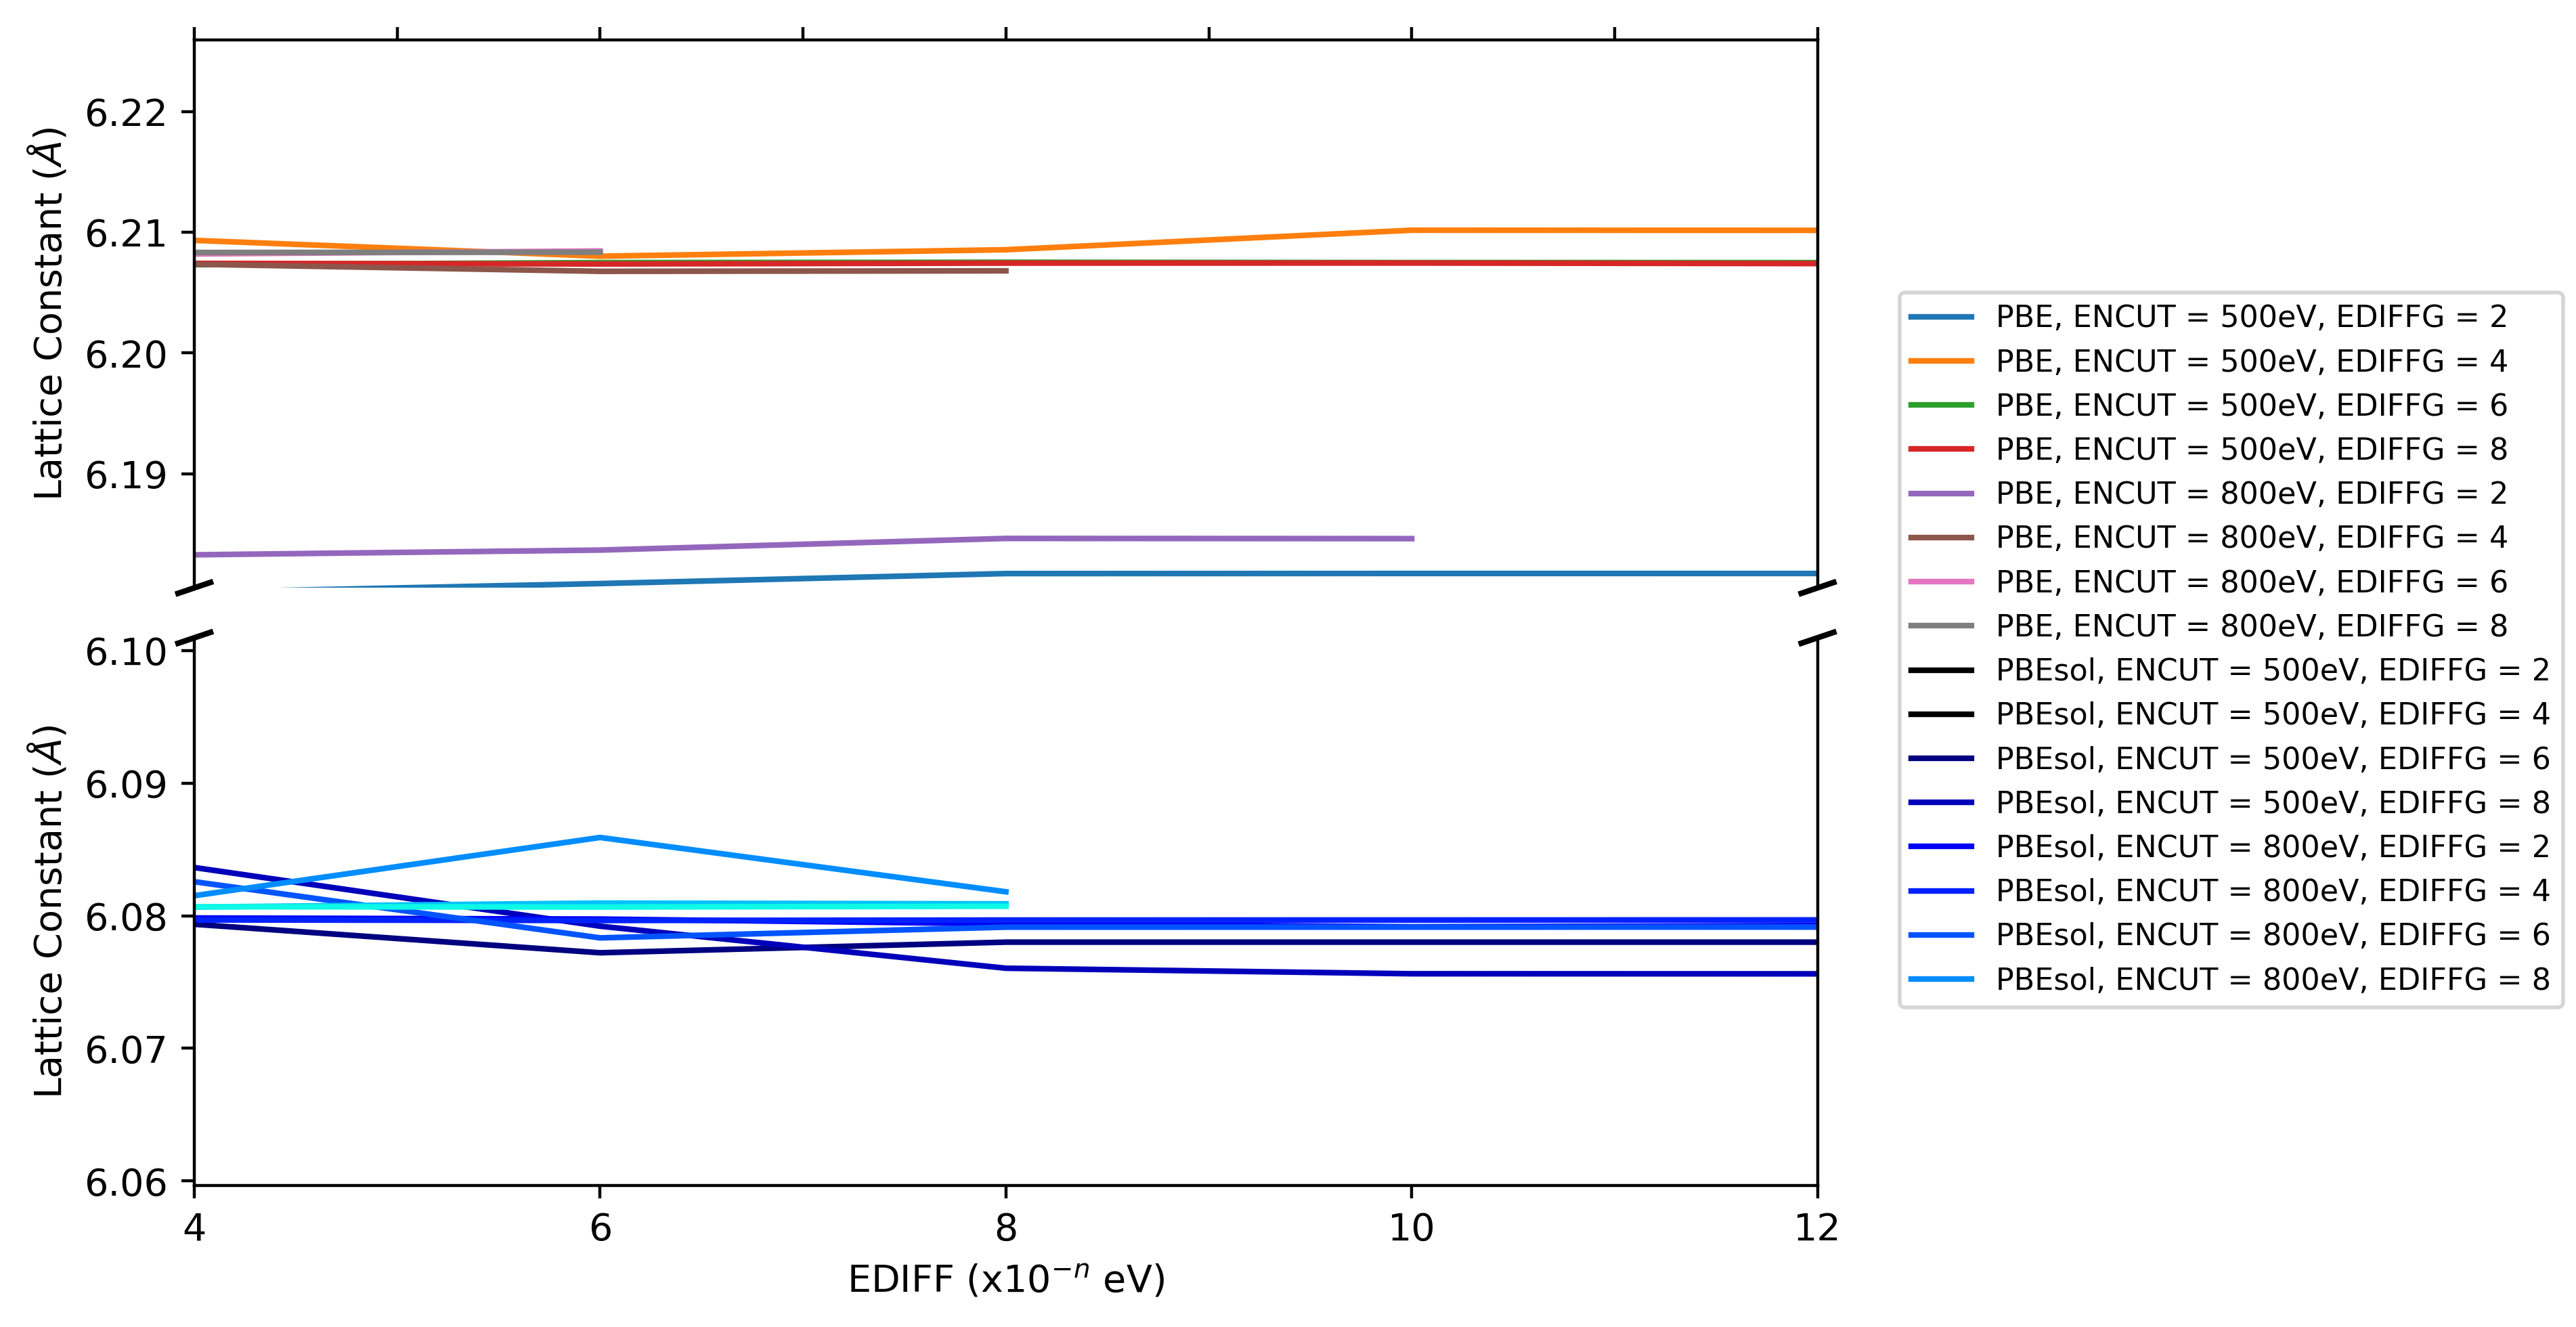

In [4]:
# EDIFF Lattice

for column in ['a','b','c']: 
        
    # Lattice a  
    fig1, (ax1, ax2) = plt.subplots(2,1, figsize=(7,5), dpi=400)
    legend = []
    colormap = plt.cm.gist_ncar
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(EDIFF_list)*len(EDIFFG_list)))))
    
    for ENCUT in ENCUT_list:
        for EDIFFG in EDIFFG_list:
            x = Reltime['EDIFF'][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBE'][Reltime['EDIFFG']==EDIFFG]
            y = Reltime[column][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBE'][Reltime['EDIFFG']==EDIFFG]
            ax1.plot(x,y)
            legend.append(str('PBE')+', ENCUT = '+str(ENCUT)+'eV, EDIFFG = '+str(EDIFFG))
    
    for ENCUT in ENCUT_list:
        for EDIFFG in EDIFFG_list:
            x = Reltime['EDIFF'][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBEsol'][Reltime['EDIFFG']==EDIFFG]
            y = Reltime[column][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBEsol'][Reltime['EDIFFG']==EDIFFG]
            ax2.plot(x,y)
            legend.append('PBEsol'+', ENCUT = '+str(ENCUT)+'eV, EDIFFG = '+str(EDIFFG))            
   
    if column == 'a':  
        errormargin = 0.008
    elif column == 'b':
        errormargin = 0.008
    elif column == 'c':
        errormargin = 0.02
        
    # zoom-in / limit the view to different portions of the data
    ax1.set_ylim(np.mean(Reltime[column][Reltime['POT']=='PBE'])-errormargin, np.mean(Reltime['a'][Reltime['POT']=='PBE'])+errormargin)  # most of the data
    ax2.set_ylim(np.mean(Reltime[column][Reltime['POT']=='PBEsol'])-errormargin, np.mean(Reltime['a'][Reltime['POT']=='PBEsol']+errormargin))  # most of the data
    
    # hide the spines between ax and ax2
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()
    
    d = .01  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
    
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal        
           
    ax1.set_xlim(min(Reltime['EDIFF']), max(Reltime['EDIFF'])) 
    ax2.set_xlim(min(Reltime['EDIFF']), max(Reltime['EDIFF'])) 
    ax2.set_xlabel('EDIFF (x10$^{-n}$ eV)')
    
    ax1.set_ylabel('Lattice Constant ($\AA$)')    
    ax2.set_ylabel('Lattice Constant ($\AA$)')   

    ax2.set_xticks(EDIFF_list)    
    
    lgd = fig1.legend(legend, fontsize = 8, loc='center right', bbox_to_anchor=(1.36, 0.5))
    fig1.tight_layout()
    fig1.savefig('EDIFF_'+column+'.png', bbox_extra_artists=(lgd,),bbox_inches='tight',pad_inches=0.16)


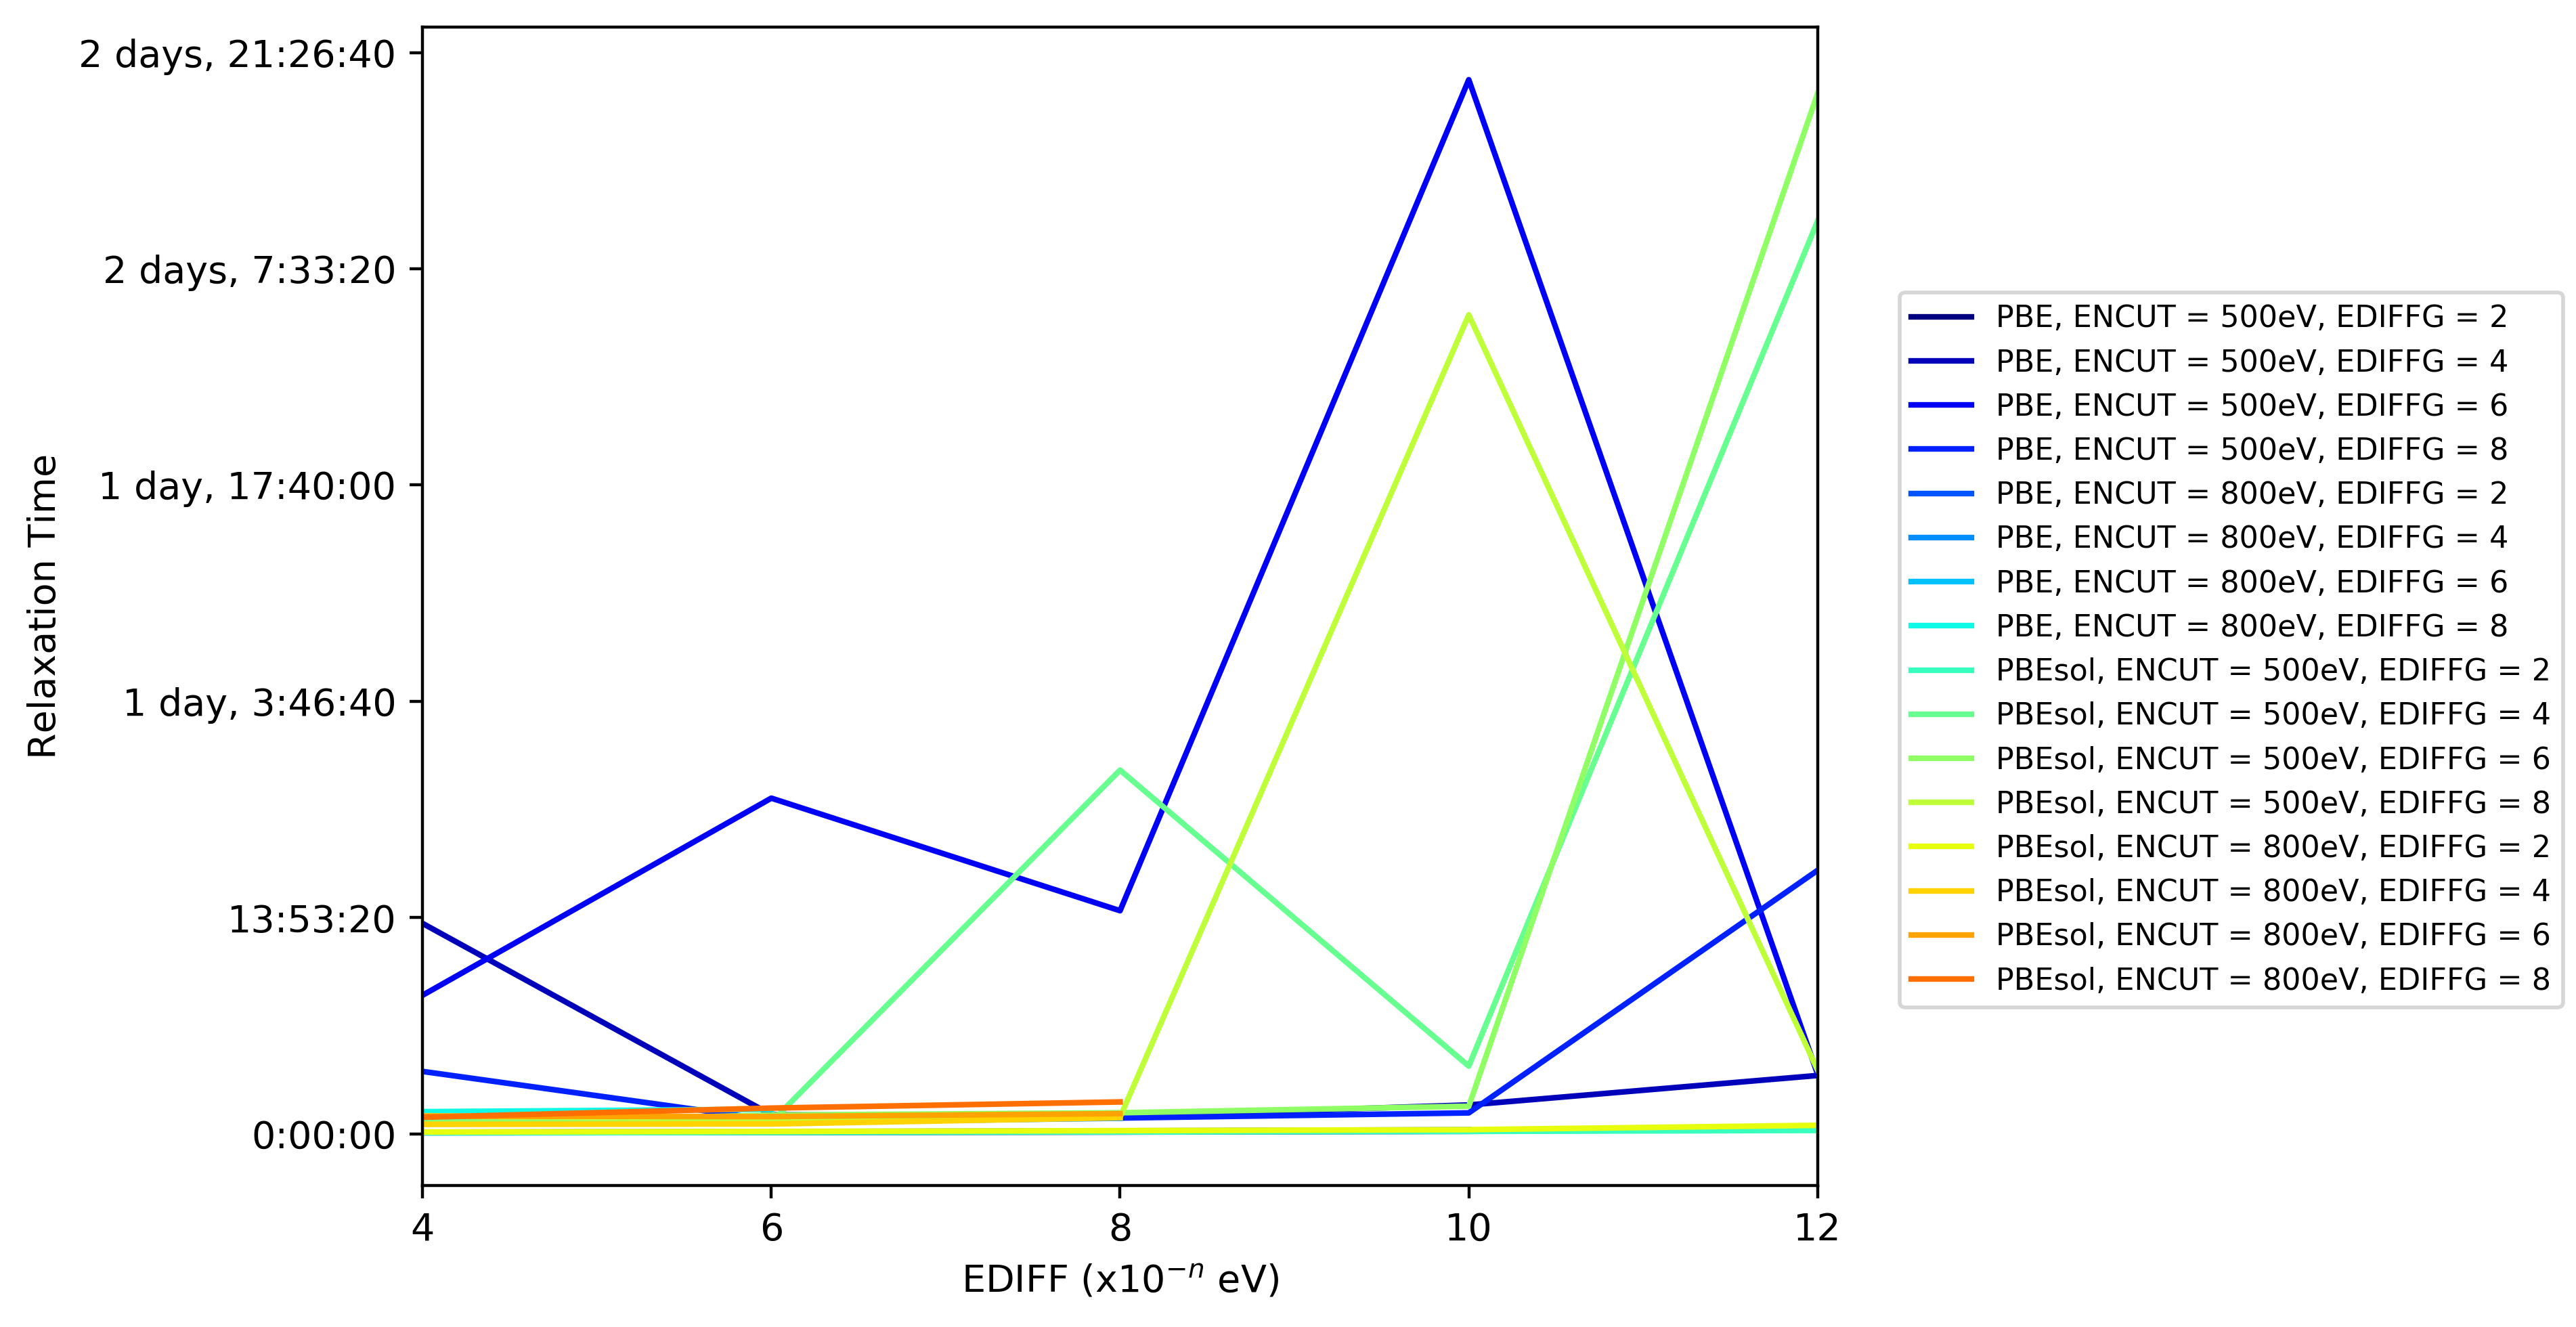

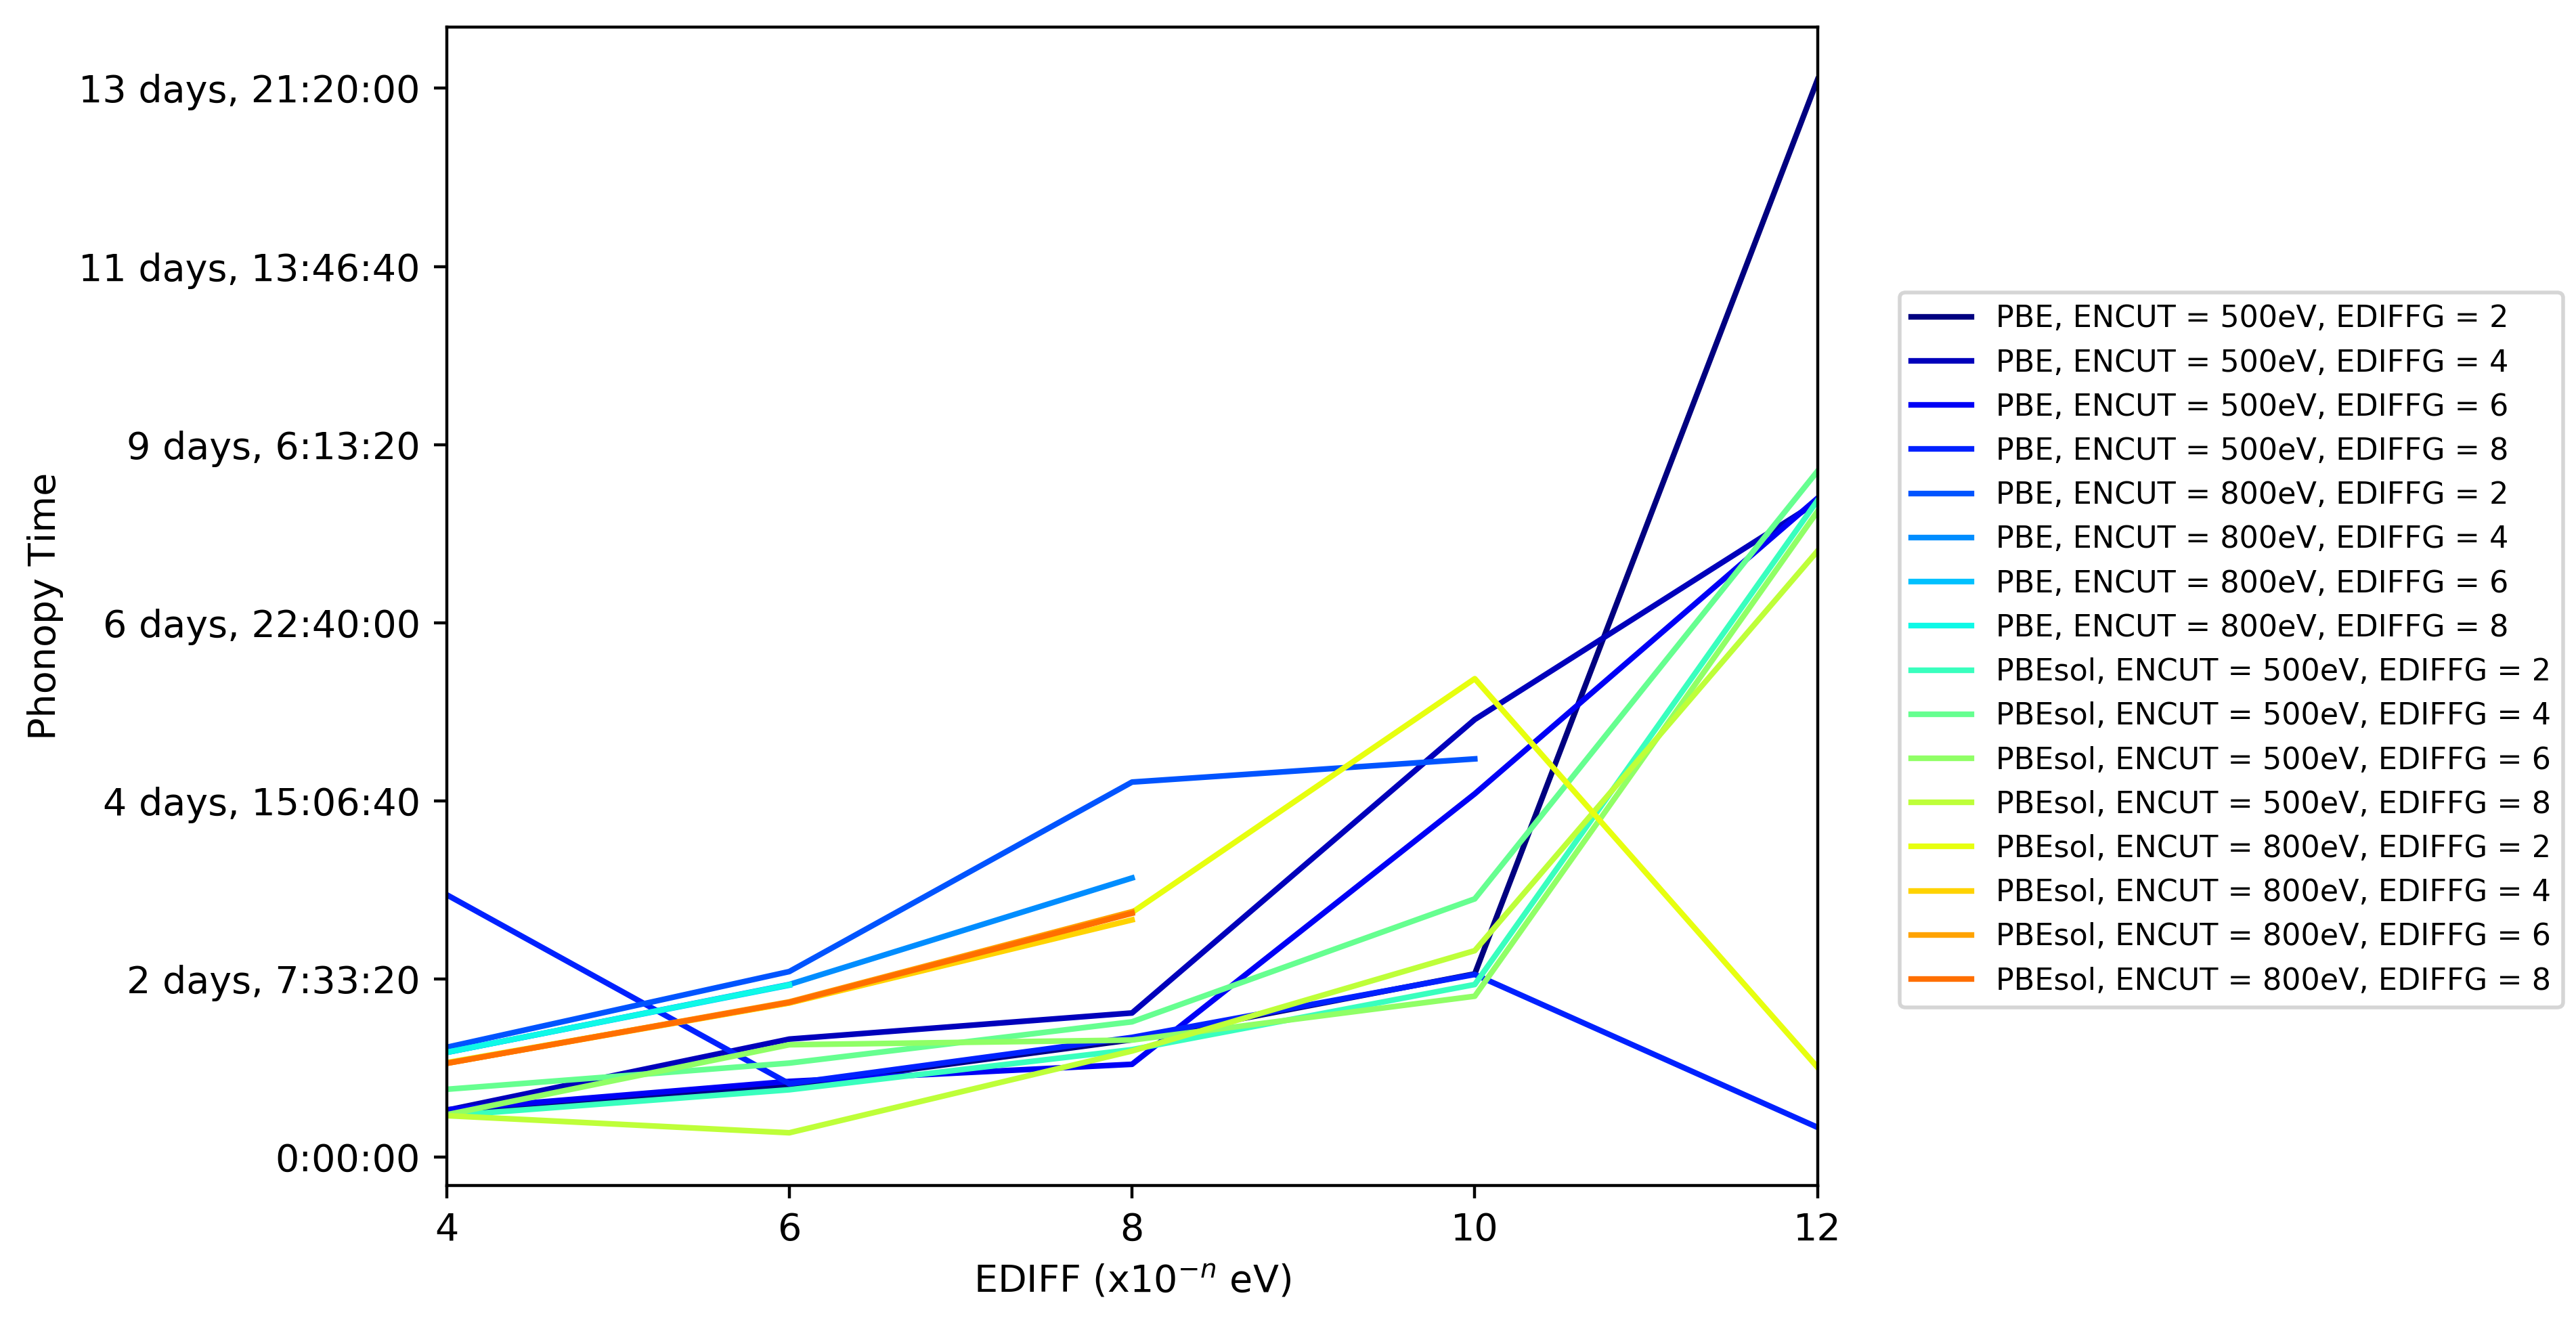

In [5]:
# Time Plots 

for column in ['Relaxation Time','Phonopy Time']: 
        
    # Time Plots 
    fig1, ax1 = plt.subplots(1,1, figsize=(7,5), dpi=400)
    legend = []
    colormap = plt.cm.gist_ncar
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(EDIFF_list)*len(EDIFFG_list)))))
    
    for ENCUT in ENCUT_list:
        for EDIFFG in EDIFFG_list:
            x = Reltime['EDIFF'][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBE'][Reltime['EDIFFG']==EDIFFG]
            y = Reltime[column][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBE'][Reltime['EDIFFG']==EDIFFG]
            ax1.plot(x,y)
            legend.append(str('PBE')+', ENCUT = '+str(ENCUT)+'eV, EDIFFG = '+str(EDIFFG))
    
    for ENCUT in ENCUT_list:
        for EDIFFG in EDIFFG_list:
            x = Reltime['EDIFF'][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBEsol'][Reltime['EDIFFG']==EDIFFG]
            y = Reltime[column][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBEsol'][Reltime['EDIFFG']==EDIFFG]
            ax1.plot(x,y)
            legend.append('PBEsol'+', ENCUT = '+str(ENCUT)+'eV, EDIFFG = '+str(EDIFFG))            
    
    #errormargin = 5000
    
    # zoom-in / limit the view to different portions of the data
    #ax1.set_ylim(np.mean(Reltime[column][Reltime['POT']=='PBE'])-errormargin, np.mean(Reltime['a'][Reltime['POT']=='PBE'])+errormargin)  # most of the data
    #ax2.set_ylim(np.mean(Reltime[column][Reltime['POT']=='PBEsol'])-errormargin, np.mean(Reltime['a'][Reltime['POT']=='PBEsol']+errormargin))  # most of the data
           
    ax1.set_xlim(min(Reltime['EDIFF']), max(Reltime['EDIFF'])) 
    ax1.set_xlabel('EDIFF (x10$^{-n}$ eV)')
    ax1.set_ylabel(column) 

    # Formatting Time Labels
    
    def convert(x, pos):
        return str(datetime.timedelta(seconds=x))
    fmt = tkr.FuncFormatter(convert)
    ax1.yaxis.set_major_formatter(fmt)

    ax1.set_xticks(EDIFF_list)    
    
    lgd = fig1.legend(legend, fontsize = 8, loc='center right', bbox_to_anchor=(1.36, 0.5))
    fig1.tight_layout()
    fig1.savefig('EDIFF_'+column+'.png', bbox_extra_artists=(lgd,),bbox_inches='tight',pad_inches=0.16)


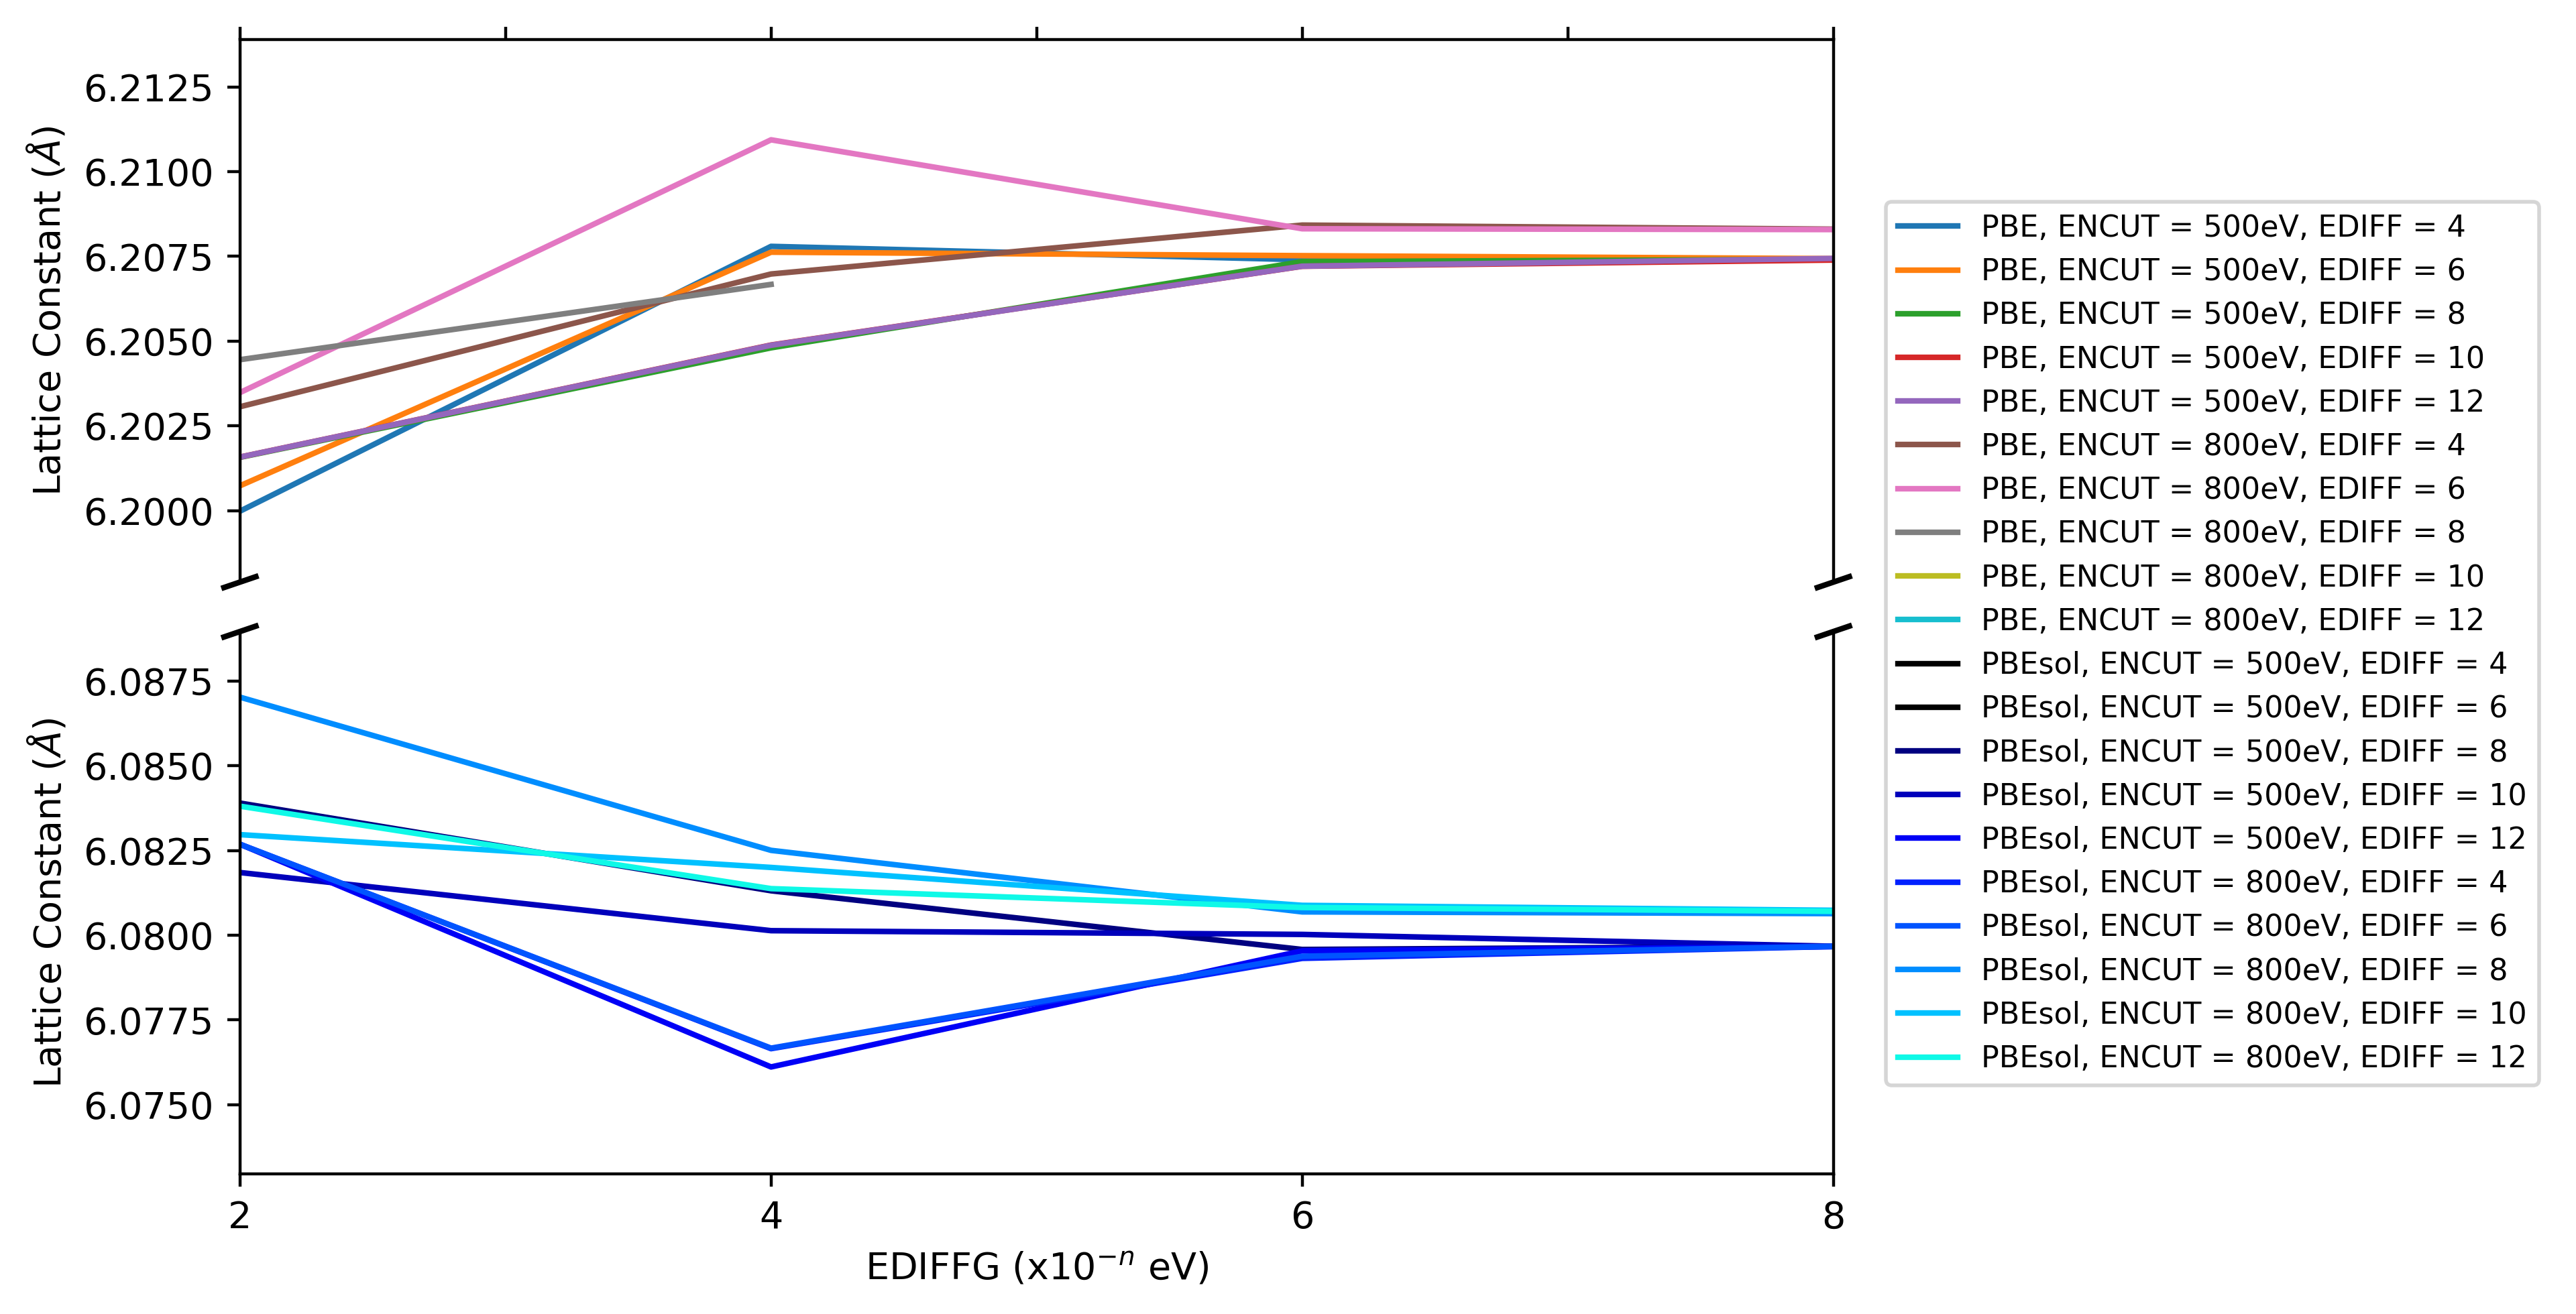

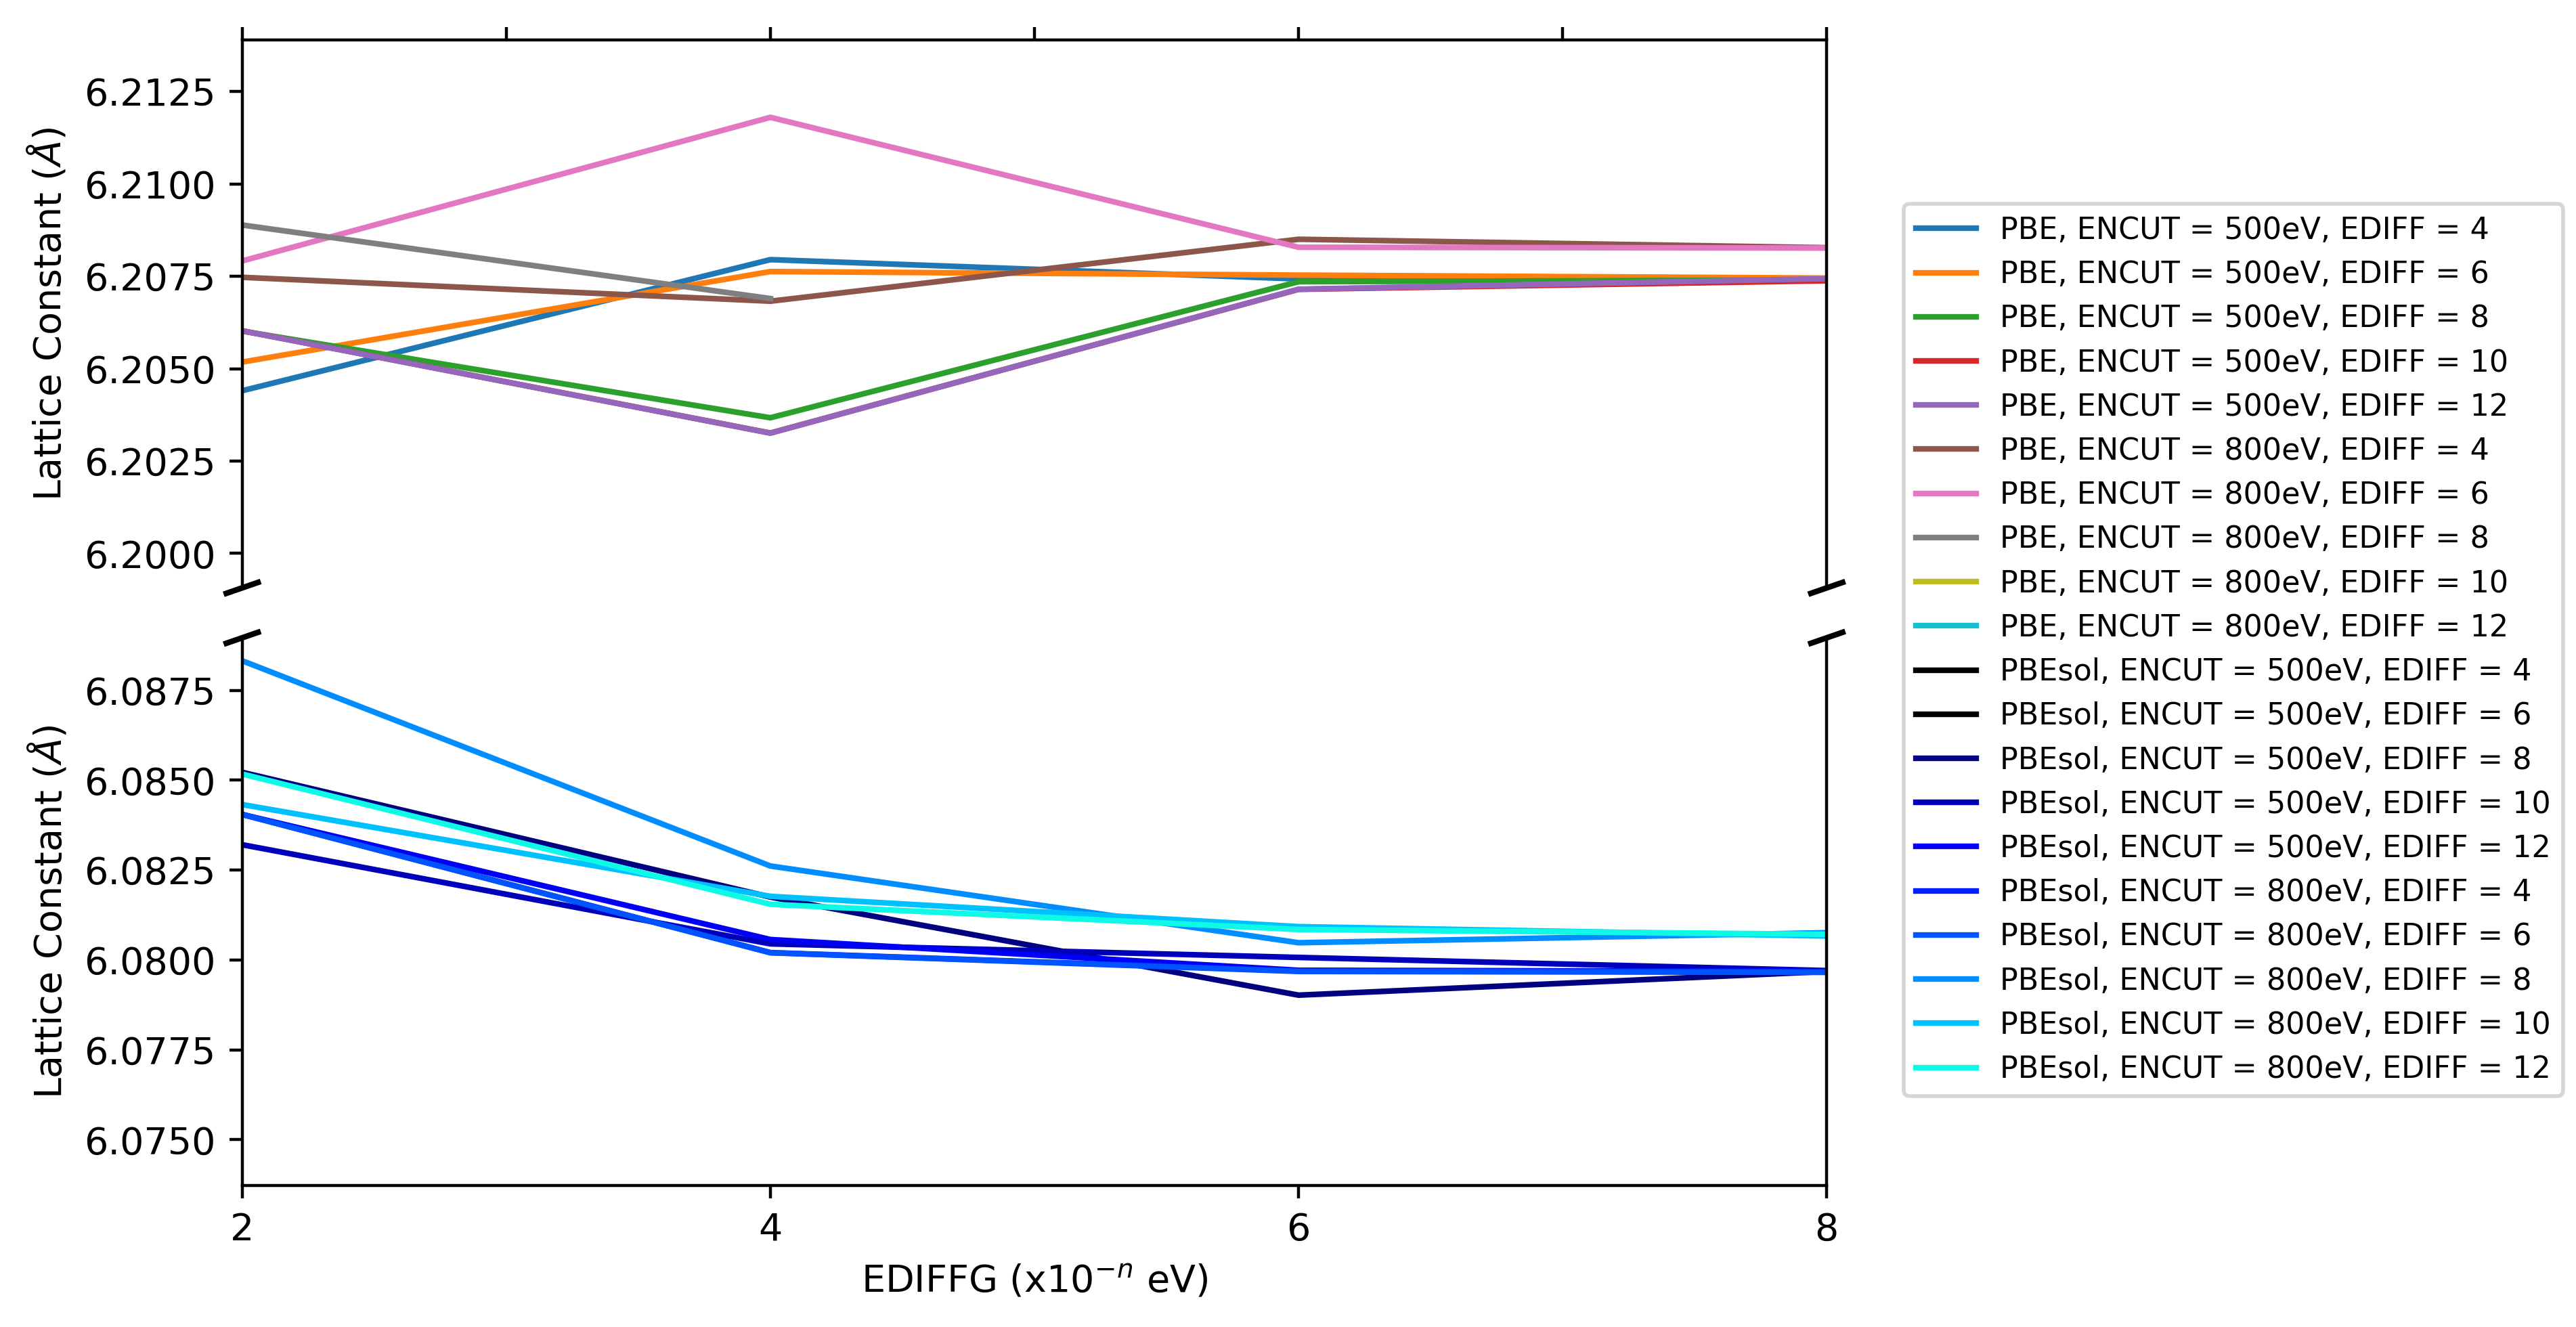

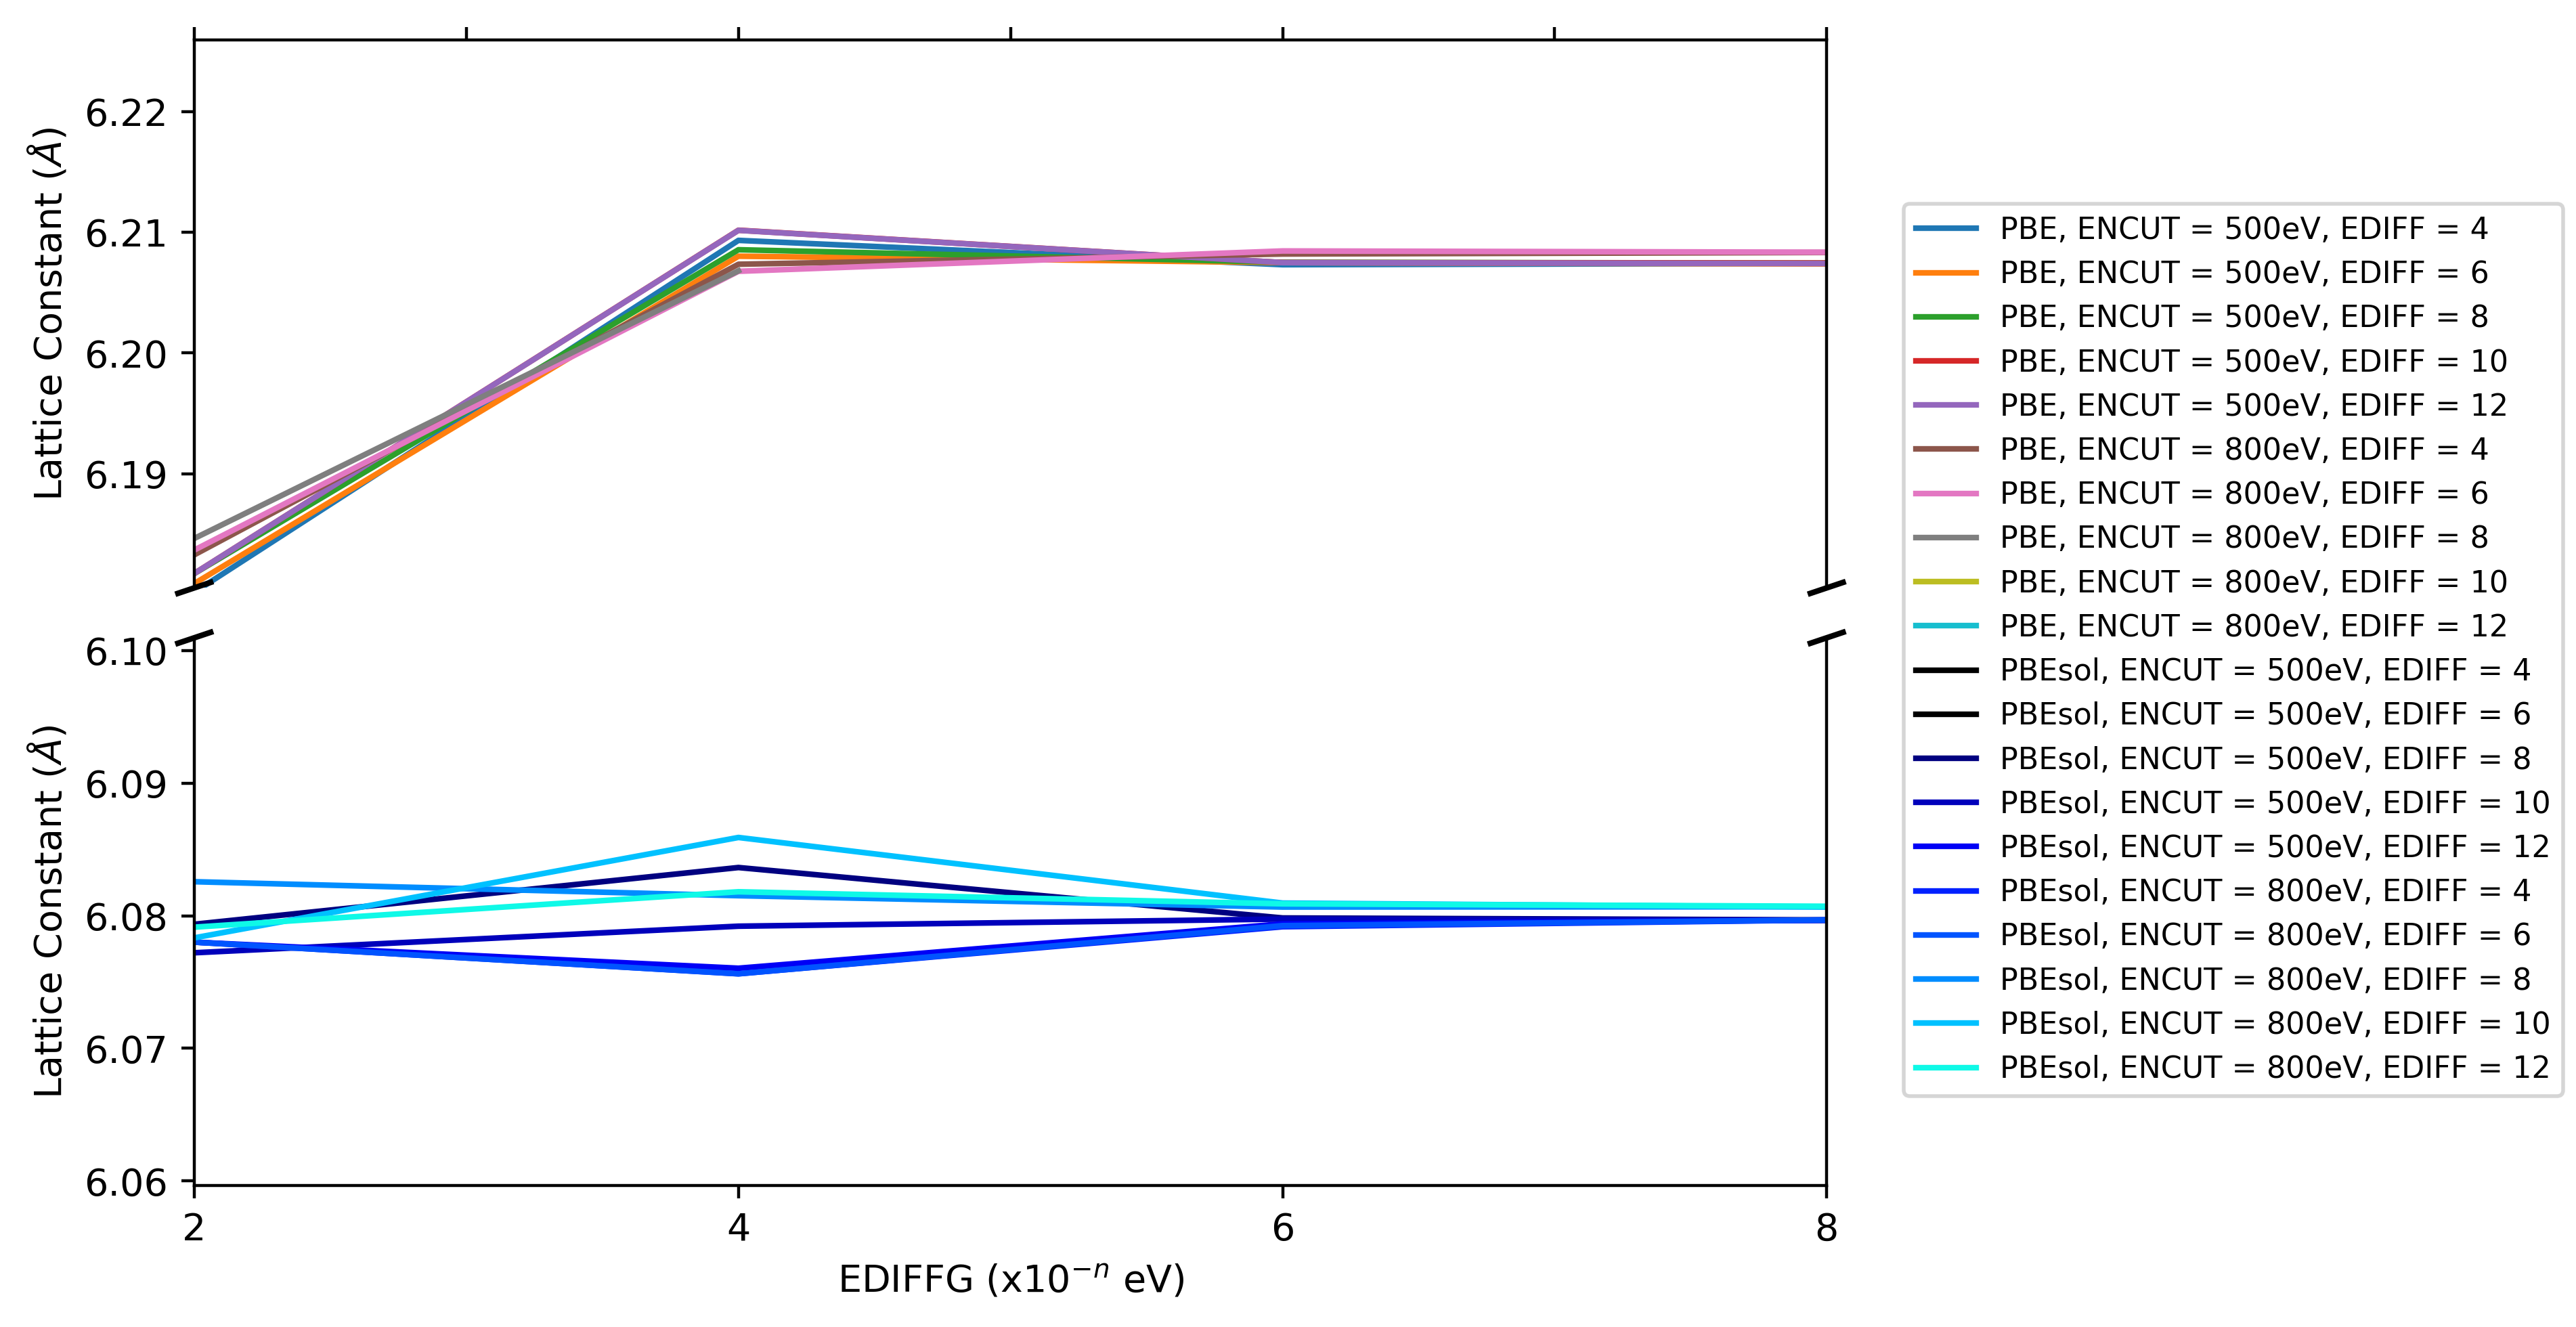

In [6]:
# EDIFFG Lattice

for column in ['a','b','c']: 
        
    # Lattice a  
    fig1, (ax1, ax2) = plt.subplots(2,1, figsize=(7,5), dpi=400)
    legend = []
    colormap = plt.cm.gist_ncar
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(EDIFF_list)*len(EDIFFG_list)))))
    
    for ENCUT in ENCUT_list:
        for EDIFF in EDIFF_list:
            x = Reltime['EDIFFG'][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBE'][Reltime['EDIFF']==EDIFF]
            y = Reltime[column][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBE'][Reltime['EDIFF']==EDIFF]
            ax1.plot(x,y)
            legend.append(str('PBE')+', ENCUT = '+str(ENCUT)+'eV, EDIFF = '+str(EDIFF))
    
    for ENCUT in ENCUT_list:
        for EDIFF in EDIFF_list:
            x = Reltime['EDIFFG'][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBEsol'][Reltime['EDIFF']==EDIFF]
            y = Reltime[column][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBEsol'][Reltime['EDIFF']==EDIFF]
            ax2.plot(x,y)
            legend.append('PBEsol'+', ENCUT = '+str(ENCUT)+'eV, EDIFF = '+str(EDIFF))            
   
    if column == 'a':  
        errormargin = 0.008
    elif column == 'b':
        errormargin = 0.008
    elif column == 'c':
        errormargin = 0.02
        
    # zoom-in / limit the view to different portions of the data
    ax1.set_ylim(np.mean(Reltime[column][Reltime['POT']=='PBE'])-errormargin, np.mean(Reltime['a'][Reltime['POT']=='PBE'])+errormargin)  # most of the data
    ax2.set_ylim(np.mean(Reltime[column][Reltime['POT']=='PBEsol'])-errormargin, np.mean(Reltime['a'][Reltime['POT']=='PBEsol']+errormargin))  # most of the data
    
    # hide the spines between ax and ax2
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()
    
    d = .01  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
    
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal        
           
    ax1.set_xlim(min(Reltime['EDIFFG']), max(Reltime['EDIFFG'])) 
    ax2.set_xlim(min(Reltime['EDIFFG']), max(Reltime['EDIFFG'])) 
    ax2.set_xlabel('EDIFFG (x10$^{-n}$ eV)')
    
    ax1.set_ylabel('Lattice Constant ($\AA$)')    
    ax2.set_ylabel('Lattice Constant ($\AA$)')   
    
    ax2.set_xticks(EDIFFG_list)


    lgd = fig1.legend(legend, fontsize = 8, loc='center right', bbox_to_anchor=(1.36, 0.5))
    fig1.tight_layout()
    fig1.savefig('EDIFFG_'+column+'.png', bbox_extra_artists=(lgd,),bbox_inches='tight',pad_inches=0.16)
  

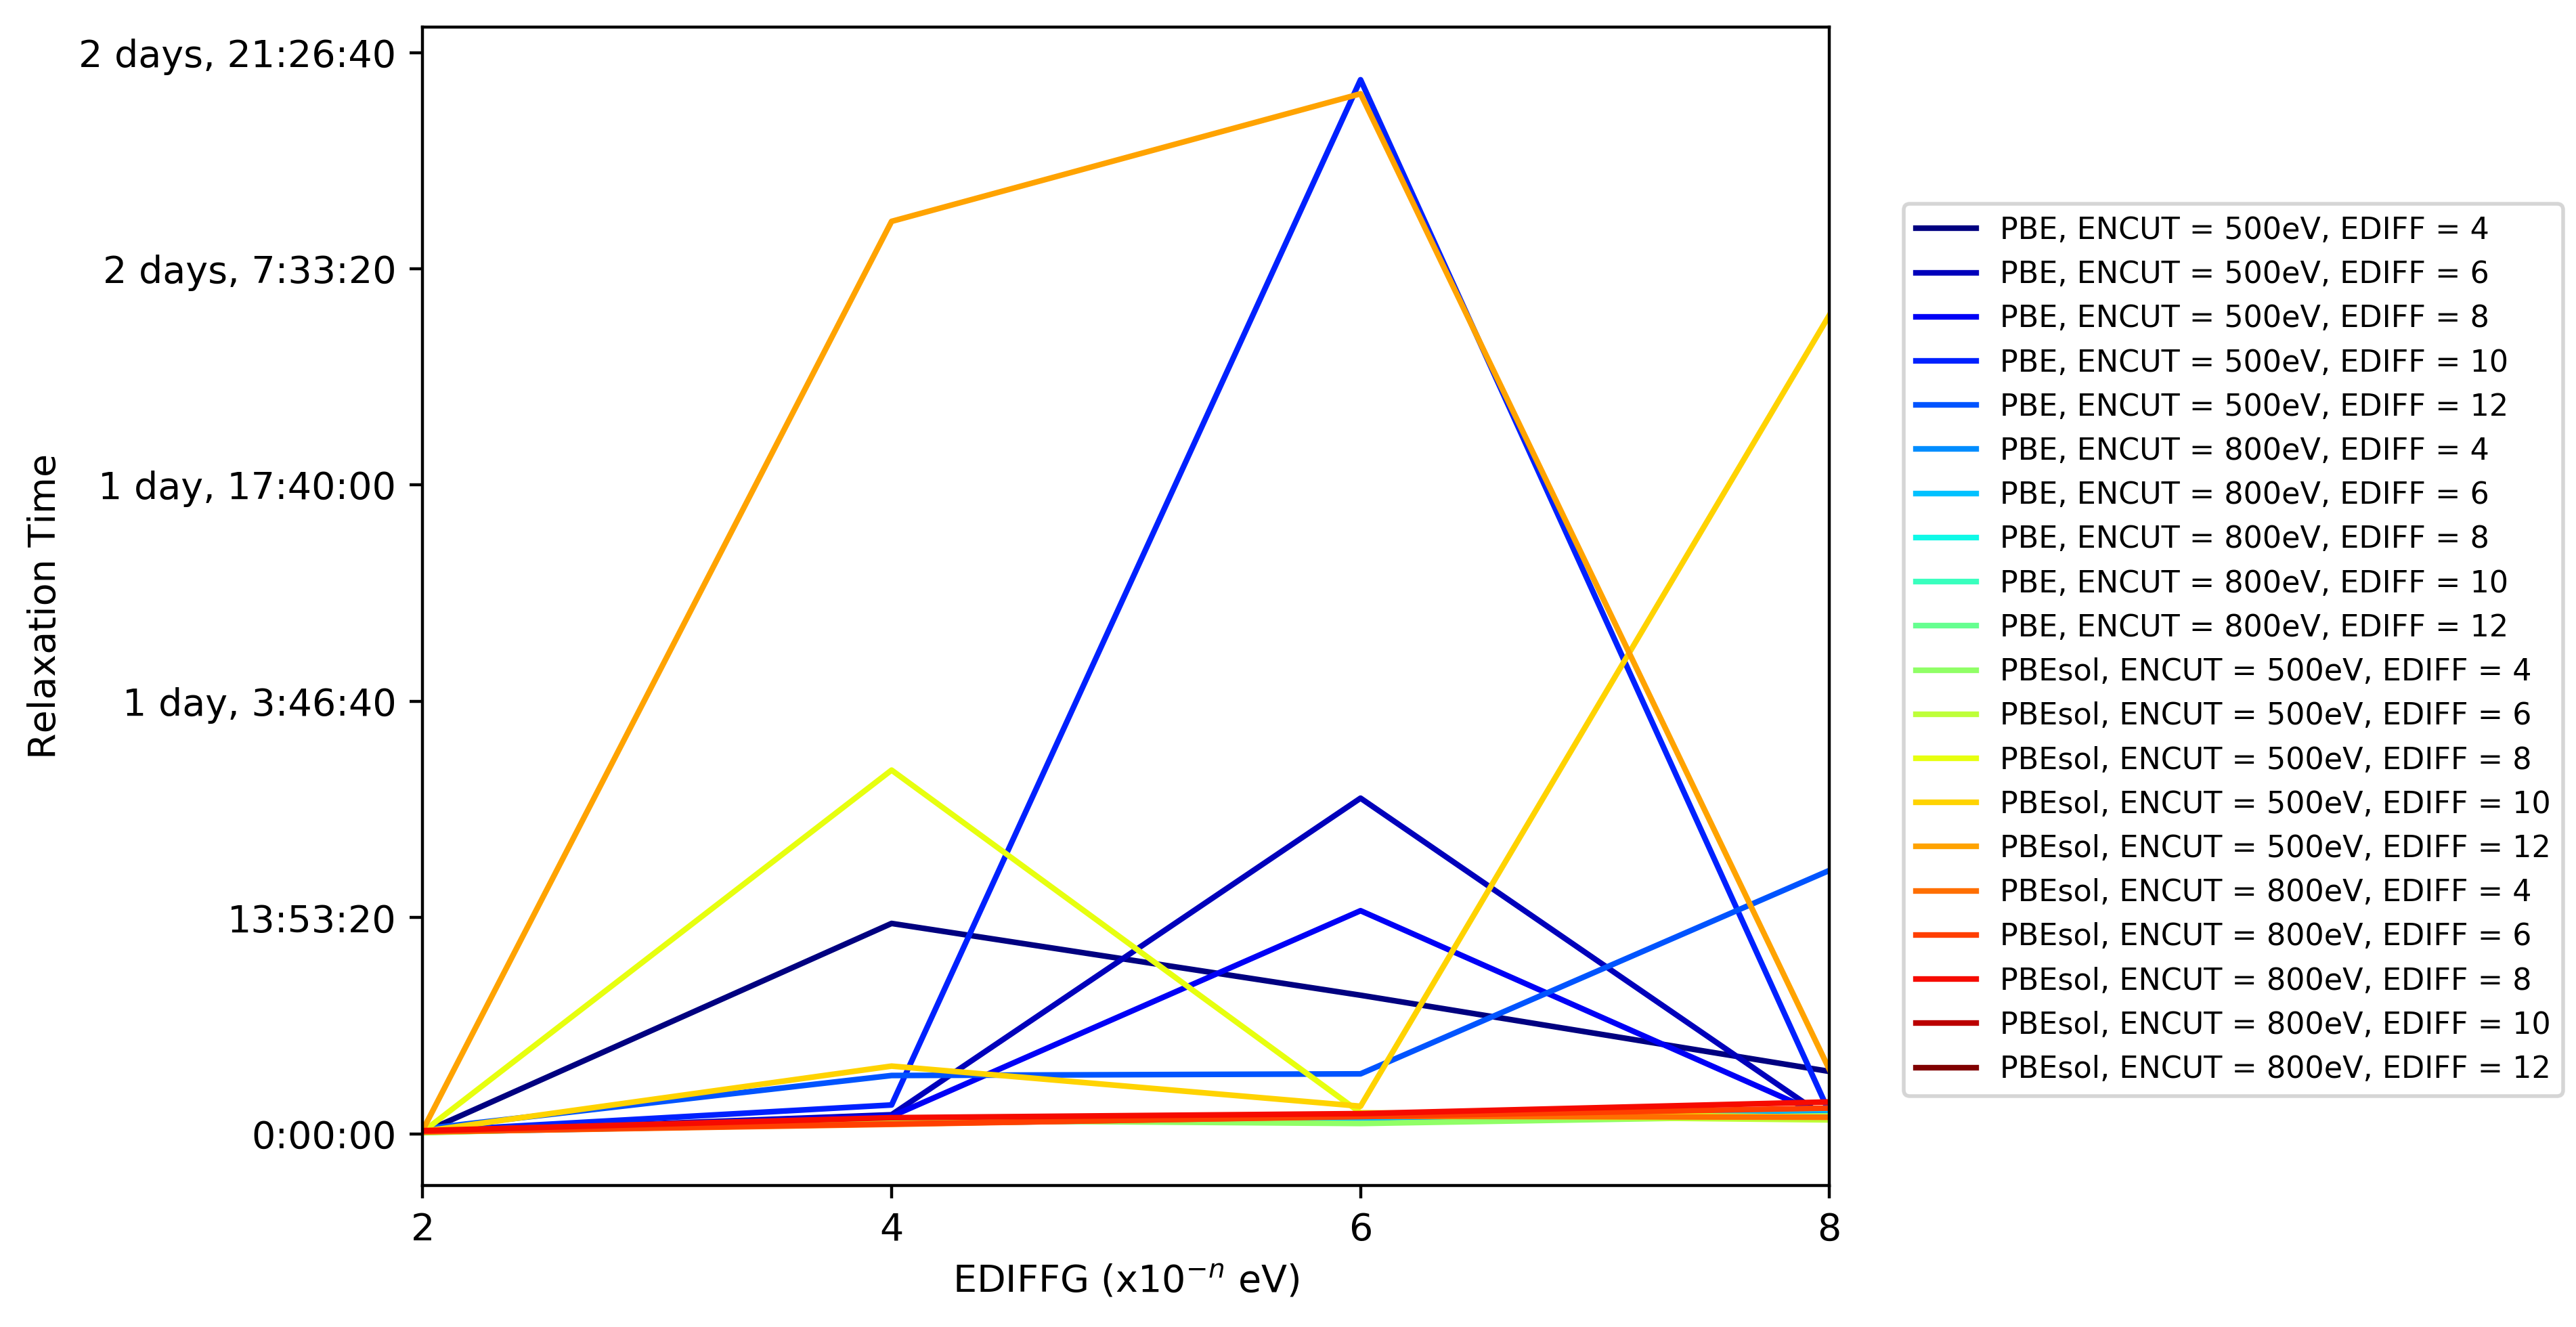

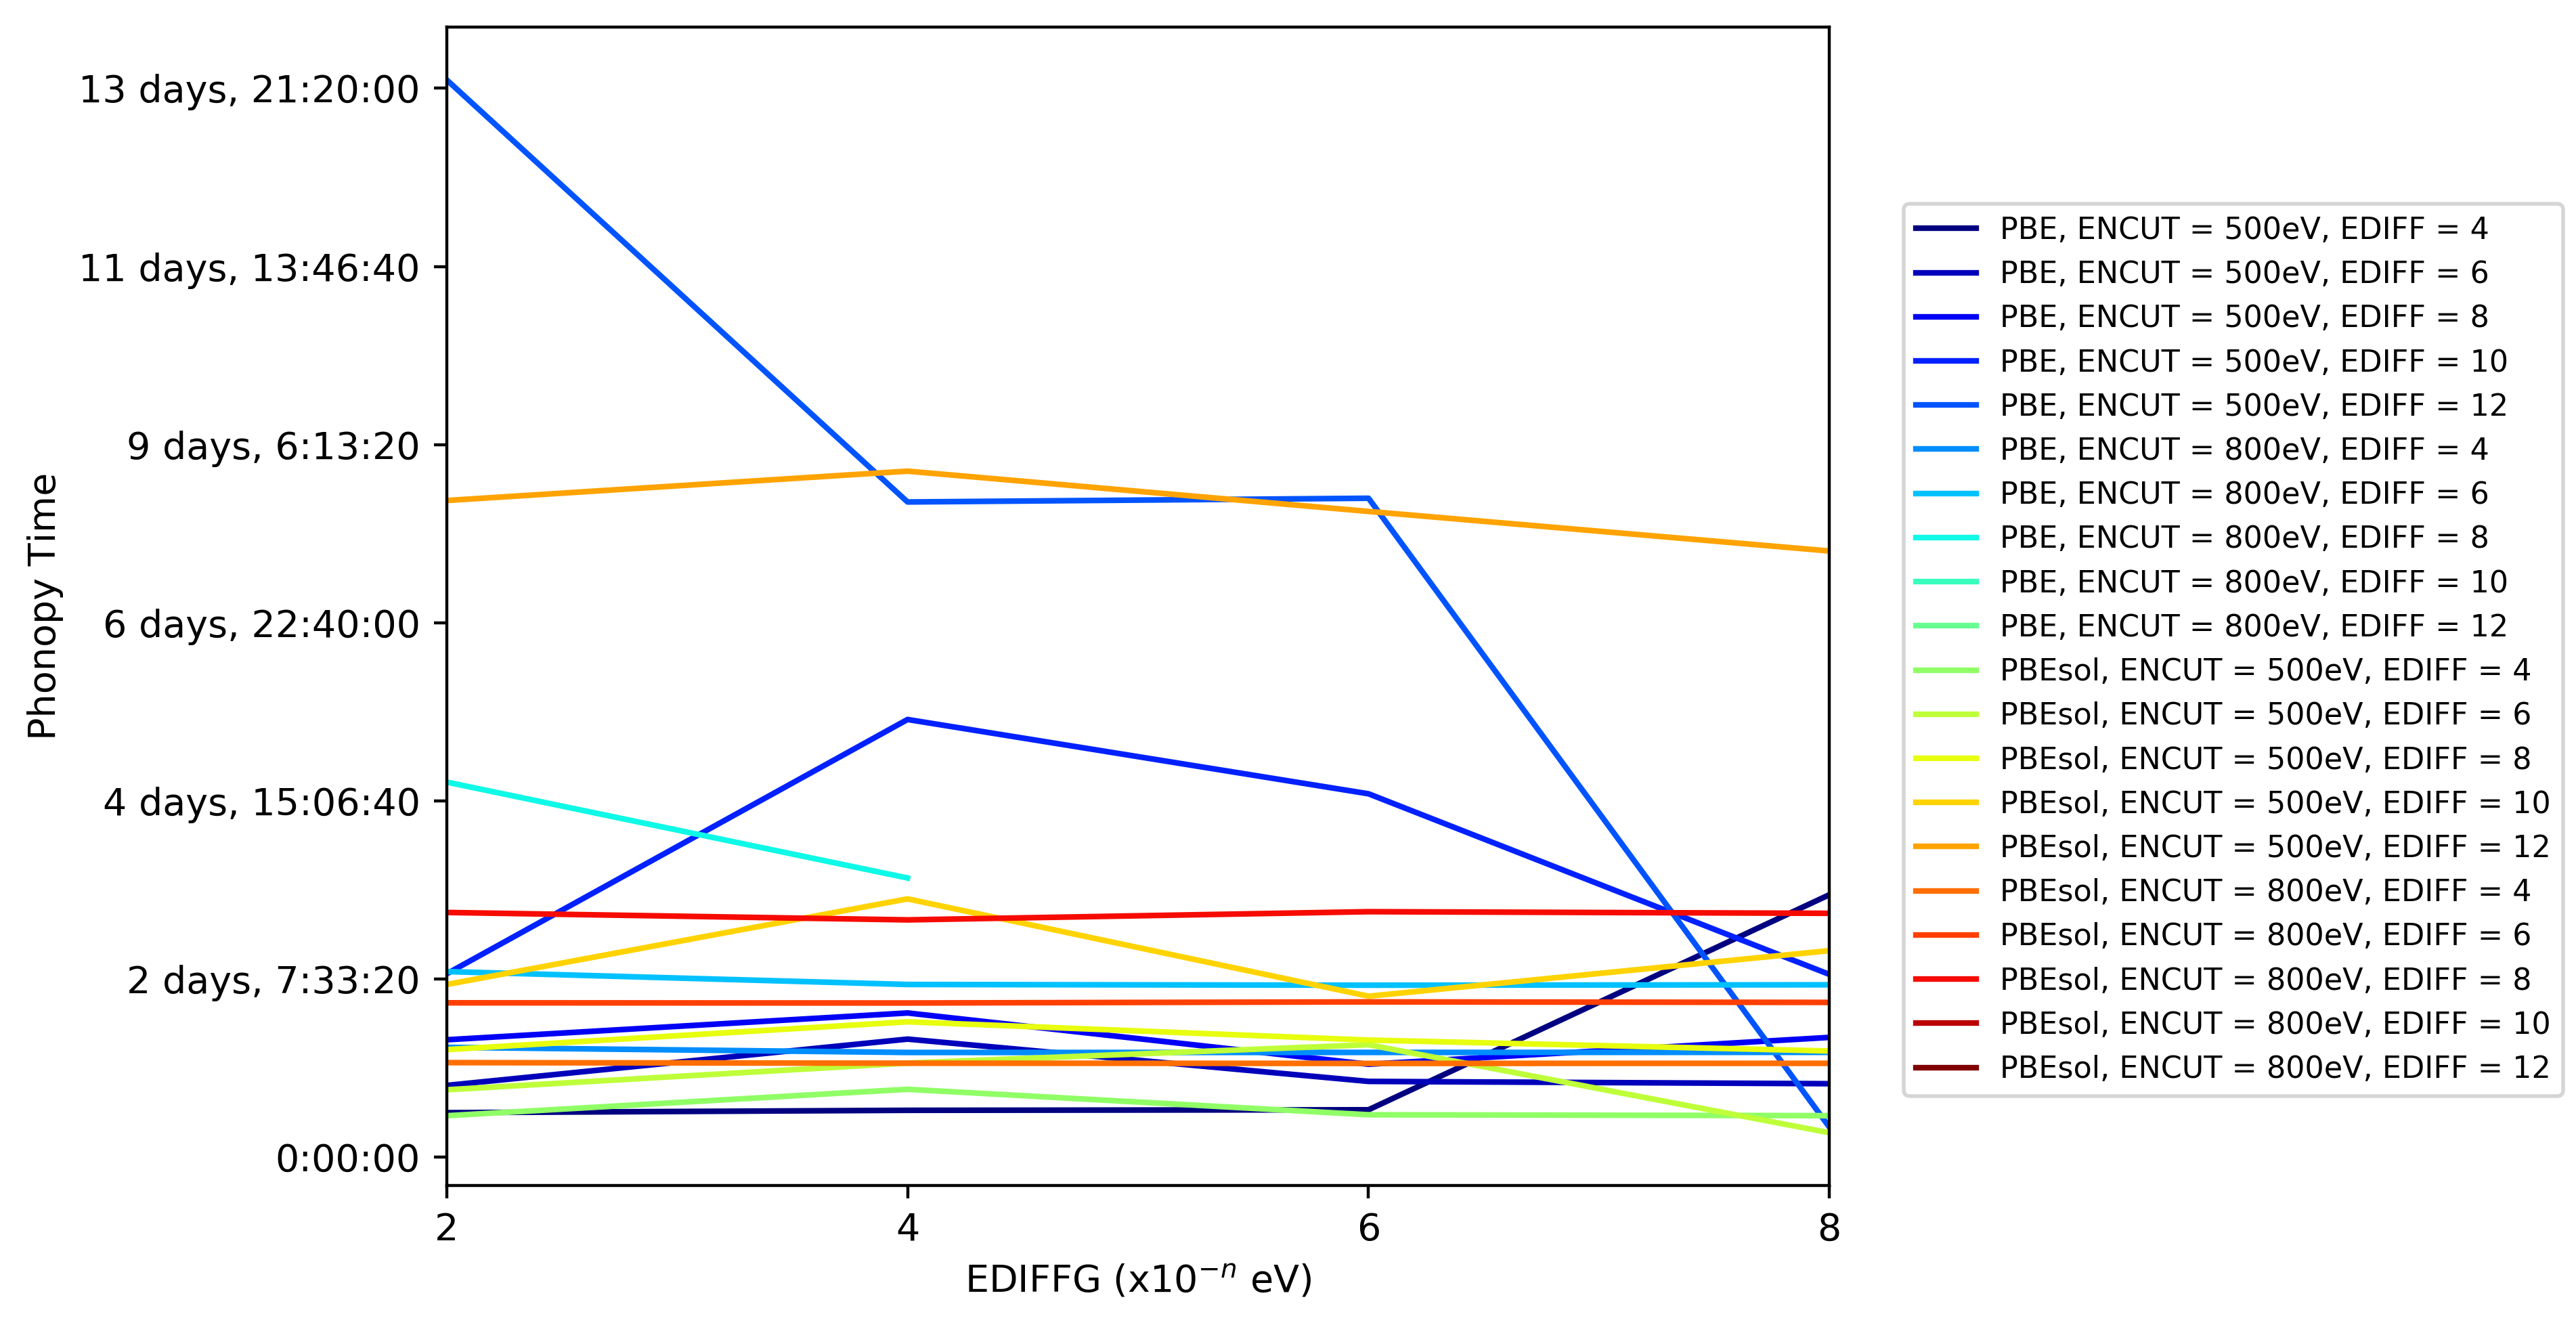

In [7]:
# Time Plots 

for column in ['Relaxation Time','Phonopy Time']: 
        
    # Time Plots 
    fig1, ax1 = plt.subplots(1,1, figsize=(7,5), dpi=400)
    legend = []
    colormap = plt.cm.gist_ncar
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(EDIFF_list)*len(EDIFFG_list)))))
    
    for ENCUT in ENCUT_list:
        for EDIFF in EDIFF_list:
            x = Reltime['EDIFFG'][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBE'][Reltime['EDIFF']==EDIFF]
            y = Reltime[column][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBE'][Reltime['EDIFF']==EDIFF]
            ax1.plot(x,y)
            legend.append(str('PBE')+', ENCUT = '+str(ENCUT)+'eV, EDIFF = '+str(EDIFF))
    
    for ENCUT in ENCUT_list:
        for EDIFF in EDIFF_list:
            x = Reltime['EDIFFG'][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBEsol'][Reltime['EDIFF']==EDIFF]
            y = Reltime[column][Reltime['ENCUT']==ENCUT][Reltime['POT']=='PBEsol'][Reltime['EDIFF']==EDIFF]
            ax1.plot(x,y)
            legend.append('PBEsol'+', ENCUT = '+str(ENCUT)+'eV, EDIFF = '+str(EDIFF))            
    
    #errormargin = 5000
    
    # zoom-in / limit the view to different portions of the data
    #ax1.set_ylim(np.mean(Reltime[column][Reltime['POT']=='PBE'])-errormargin, np.mean(Reltime['a'][Reltime['POT']=='PBE'])+errormargin)  # most of the data
    #ax2.set_ylim(np.mean(Reltime[column][Reltime['POT']=='PBEsol'])-errormargin, np.mean(Reltime['a'][Reltime['POT']=='PBEsol']+errormargin))  # most of the data
           
    ax1.set_xlim(min(Reltime['EDIFFG']), max(Reltime['EDIFFG'])) 
    ax1.set_xlabel('EDIFFG (x10$^{-n}$ eV)')
    ax1.set_ylabel(column) 
        
    # Formatting Time Labels
    def convert(x, pos):
        return str(datetime.timedelta(seconds=x))
    fmt = tkr.FuncFormatter(convert)
    ax1.yaxis.set_major_formatter(fmt)
    
    ax1.set_xticks(EDIFFG_list)
    
    lgd = fig1.legend(legend, fontsize = 8, loc='center right', bbox_to_anchor=(1.36, 0.5))
    fig1.tight_layout()
    fig1.savefig('EDIFFG_'+column+'.png', bbox_extra_artists=(lgd,),bbox_inches='tight',pad_inches=0.16)



### The following cells generate 3D surface plots in the following order: 

* Lattice Paramters 
* Run Times

These are a bit redundant, as there are interactive 3D plots below, but may be useful later. 

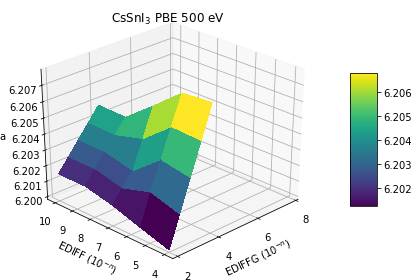

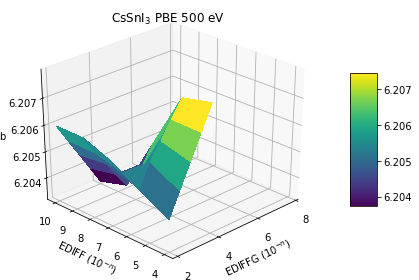

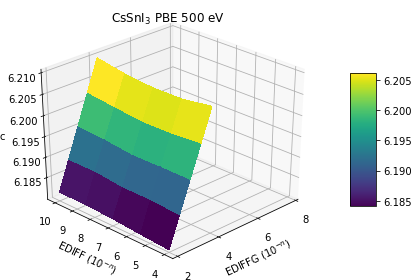

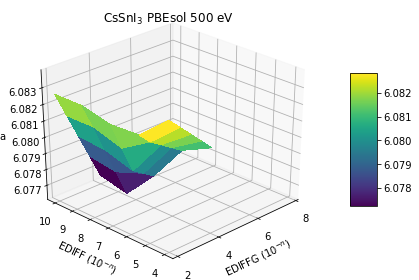

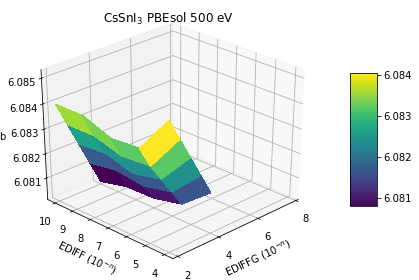

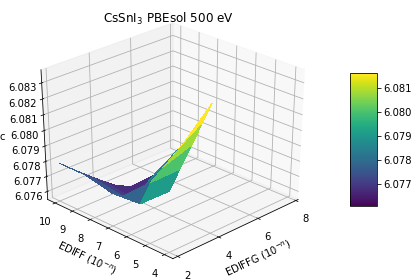

In [8]:

# 3D Plot 
for ENCUT in [500]:
    for POT in POT_list:
        for column in ['a','b','c']: 
            
            X = [] 
            Y = []
            Z = []
            
            for EDIFFG in EDIFFG_list[0:2]:
                for EDIFF in EDIFF_list[0:-1]:
                    X.append(EDIFFG)
                    Y.append(EDIFF)
                    Z.append(Reltime[column][Reltime['ENCUT']==ENCUT][Reltime['POT']==POT][Reltime['EDIFF']==EDIFF][Reltime['EDIFFG']==EDIFFG].values[0])
            '''        
            print('X: ', X)    
            print('Y: ', Y)   
            print('Z: ', Z)
            '''
            
            plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),5),\
                                       np.linspace(np.min(Y),np.max(Y),5))
            plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')
            
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            surf = ax.plot_surface(plotx,ploty,plotz,cstride=1,rstride=1,cmap='viridis',linewidth=0, antialiased=False)  # or 'hot'
            ax.set_xlabel('EDIFFG (10$^{-n}$)')
            ax.set_ylabel('EDIFF (10$^{-n}$)')
            ax.set_zlabel(column)
            ax.set_title('CsSnI$_3$ '+POT+' '+str(ENCUT)+' eV')
            ax.view_init(30,225)   
            ax.set_xticks(EDIFFG_list)
            
            fig.colorbar(surf, shrink=0.5, aspect=5)
            fig.tight_layout()
            fig.savefig('3D_'+column+POT+str(ENCUT)+'eV.png', bbox_extra_artists=(lgd,),bbox_inches='tight',pad_inches=0.16, dpi = 200)

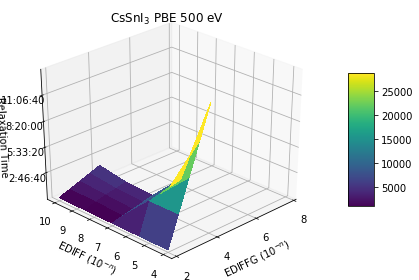

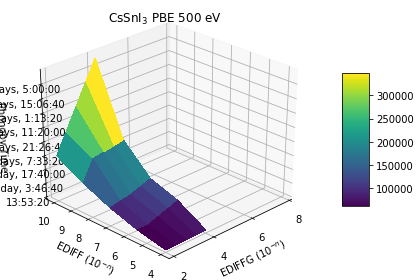

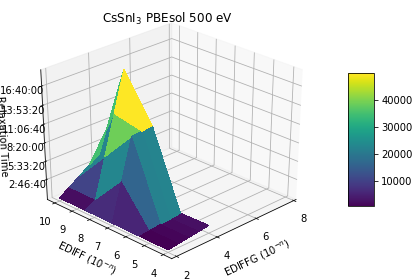

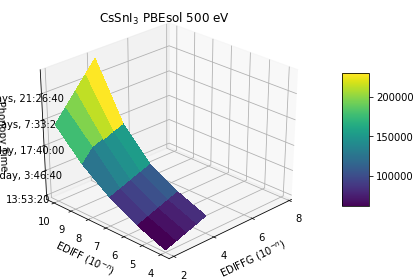

In [9]:
# 3D Plot 
for ENCUT in [500]:
    for POT in POT_list:
        for column in ['Relaxation Time','Phonopy Time']: 
            
            X = [] 
            Y = []
            Z = []
            
            for EDIFFG in EDIFFG_list[0:2]:
                for EDIFF in EDIFF_list[0:-1]:
                    X.append(EDIFFG)
                    Y.append(EDIFF)
                    Z.append(Reltime[column][Reltime['ENCUT']==ENCUT][Reltime['POT']==POT][Reltime['EDIFF']==EDIFF][Reltime['EDIFFG']==EDIFFG].values[0])
             
            '''
            print('X: ', X)    
            print('Y: ', Y)   
            print('Z: ', Z)
            '''
            
            plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),5),\
                                       np.linspace(np.min(Y),np.max(Y),5))
            plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')
            
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            surf = ax.plot_surface(plotx,ploty,plotz,cstride=1,rstride=1,cmap='viridis',linewidth=0, antialiased=False)  # or 'hot'
            ax.set_xlabel('EDIFFG (10$^{-n}$)')
            ax.set_ylabel('EDIFF (10$^{-n}$)')
            ax.set_zlabel(column)
            ax.set_title('CsSnI$_3$ '+POT+' '+str(ENCUT)+' eV')
            ax.view_init(30,225) 
            ax.set_xticks(EDIFFG_list)
            
                # Formatting Time Labels
            def convert(x, pos):
                return str(datetime.timedelta(seconds=x))
            fmt = tkr.FuncFormatter(convert)
            ax.zaxis.set_major_formatter(fmt)
            
            fig.colorbar(surf, shrink=0.5, aspect=5)
            fig.tight_layout()
            fig.savefig('3D_'+column+POT+str(ENCUT)+'eV.png', bbox_extra_artists=(lgd,),bbox_inches='tight', dpi = 200)


### The following cells generate interactive 3D surface plots in the following order: 

* Lattice Paramters 
* Run Times

This also saves these as .html files. 

In [10]:
#Trying ipyvolume

# 3D Plot 
for ENCUT in [500]:
    for POT in POT_list:
        for column in ['a','b','c']: 
        
            Z = [] 
            for EDIFFG in EDIFFG_list[:3]:
                for EDIFF in EDIFF_list[:]:
                    Z.append(Reltime[column][Reltime['ENCUT']==ENCUT][Reltime['POT']==POT][Reltime['EDIFF']==EDIFF][Reltime['EDIFFG']==EDIFFG].values[0]) 
            
            X = EDIFF_list[:]
            Y = EDIFFG_list[:3]
            
            '''
            print('X: ', X)    
            print('Y: ', Y)   
            print('Z: ', Z)
            '''
            
            z = np.array(Z).reshape((len(Y), len(X)))


            fig = go.Figure()
            fig.add_trace(
                go.Surface(
                    name = "Surface",
                    x = X,
                    y = Y,
                    z = z,
                    contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True)
                )
            )

            fig.update_layout(
                title = str(POT)+' '+str(ENCUT)+'eV '+str(column),
                scene = dict(
                    xaxis_title = "EDIFF (10<sup>-n</sup>)",
                    yaxis_title = "EDIFFG (10<sup>-n</sup>)",
                    zaxis_title = str(column)+' (Å)'
                    )
                )

            fig.update_layout(
                scene = dict(
                    xaxis = dict(nticks=6, range=[4,13],),
                                 yaxis = dict(nticks=4, range=[2,9],),
                                 zaxis = dict(nticks=8, range=[min(Z),max(Z)],),))
            
            fig.show()
            filename = str(POT)+'_'+str(ENCUT)+'eV_'+str(column)+'.html'
            fig.write_html(filename)

In [11]:
#Trying ipyvolume

# 3D Plot 
for ENCUT in [500,800]:
    for POT in POT_list:
        for column in ['Relaxation Time','Phonopy Time']: 
        
            Z = []
            missing = [] 
            for EDIFFG in EDIFFG_list[:]:
                for EDIFF in EDIFF_list[:]:
                    try: 
                        Z.append(Reltime[column][Reltime['ENCUT']==ENCUT][Reltime['POT']==POT][Reltime['EDIFF']==EDIFF][Reltime['EDIFFG']==EDIFFG].values[0]) 
                    except IndexError:
                        Z.append(0)
                        missing.append(0)
                        
            print('There are '+ str(len(missing)) + ' missing value(s) in the following plot:')
                    
            X = EDIFF_list[:]
            Y = EDIFFG_list[:]
            
            '''
            print('X: ', X)    
            print('Y: ', Y)   
            print('Z: ', Z)
            '''
            
            z = np.array(Z).reshape((len(Y), len(X)))


            fig = go.Figure()
            fig.add_trace(
                go.Surface(
                    name = "Surface",
                    x = X,
                    y = Y,
                    z = z,
                    contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True)
                )
            )

            fig.update_layout(
                title = str(POT)+' '+str(ENCUT)+'eV '+str(column),
                scene = dict(
                    xaxis_title = "EDIFF (10<sup>-n</sup>)",
                    yaxis_title = "EDIFFG (10<sup>-n</sup>)",
                    zaxis_title = str(column)+' (s)'
                ), 
            )
            
            fig.update_layout(
                scene = dict(
                    xaxis = dict(nticks=6, range=[4,13],),
                                 yaxis = dict(nticks=4, range=[2,9],),
                                 zaxis = dict(nticks=8, range=[0,max(Z)],),))
            
            fig.show()
            filename = str(POT)+'_'+str(ENCUT)+'eV_'+str(column)+'.html'
            fig.write_html(filename)

There are 0 missing value(s) in the following plot:


There are 0 missing value(s) in the following plot:


There are 0 missing value(s) in the following plot:


There are 0 missing value(s) in the following plot:


There are 9 missing value(s) in the following plot:


There are 9 missing value(s) in the following plot:


There are 6 missing value(s) in the following plot:


There are 6 missing value(s) in the following plot:


### The following cells generate annotated heatmaps for negative frequency location. 

In [20]:
# Negative Frequencies

print('Note to future Cam, I made a .csv of all the negative frequencies by hand, then imported that. You will need to redo it for the rest of the dataset. Bit of a longting, soz m8. \n')
print('\nAlso, make a new for loop for ENCUT when you have more data')

Negfreq = pd.read_csv('negativefrequenciesfile.csv', header = 0, index_col = 0, delimiter=',', encoding="utf-8-sig")

FreqData = pd.merge(Negfreq, Reltime)
FreqData = FreqData.dropna()

#Add a loop for ENCUT here later.. 
for ENCUT in [500]:
    for POT in POT_list: 
        NegFreqMap = []
        NegFreqMapLabels = []
        for EDIFFG in EDIFFG_list:
            for EDIFF in EDIFF_list:
                value = FreqData['Negativefrequencies'][FreqData['ENCUT']==ENCUT][FreqData['POT']==POT][FreqData['EDIFF']==EDIFF][FreqData['EDIFFG']==EDIFFG].values
                if value == 'N': 
                    NegFreqMap.append(0)
    #               NegFreqMapLabels.append('Positive '+str(Full_Data['Phonopy Time'][Reltime['ENCUT']==ENCUT][Reltime['POT']==POT][Reltime['EDIFF']==EDIFF][Reltime['EDIFFG']==EDIFFG].values[0]))
                    NegFreqMapLabels.append('Positive Only')
                elif value == 'Y': 
                    NegFreqMap.append(1)
                    NegFreqMapLabels.append('Negative')
                else: 
                    print('Missing NegFreq Value! Check the CSV!', EDIFF, EDIFFG, POT, ENCUT, FreqData['Negativefrequencies'][FreqData['ENCUT']==ENCUT][Reltime['POT']==POT][Reltime['EDIFF']==EDIFF][Reltime['EDIFFG']==EDIFFG].values)

        NegFreqMap = np.array(NegFreqMap).reshape((len(EDIFFG_list), len(EDIFF_list)))
        NegFreqMapLabels = np.array(NegFreqMapLabels).reshape((len(EDIFFG_list), len(EDIFF_list)))

        # Labels 
        EDIFFG_Label, EDIFF_Label = [],[]
        for EDIFFG in EDIFFG_list[:]:
            EDIFFG_Label.append('EDIFFG = ' + str(EDIFFG))
        for EDIFF in EDIFF_list[:]:
            EDIFF_Label.append('EDIFF = ' + str(EDIFF))

        colorscale=[[0.0, 'rgb(0,255,128)'],[1.0, 'rgb(255, 0, 64)']]

        fig = ff.create_annotated_heatmap(NegFreqMap,
                        x=EDIFF_Label,
                        y=EDIFFG_Label,
                        annotation_text=NegFreqMapLabels,
                        colorscale=colorscale)
        fig.update_layout(title_text=str(POT)+' ENCUT = '+ str(ENCUT) + ' Negative Frequencies')
        fig.show()
        fig.to_image(format="png", engine="kaleido")
        fig.write_image(str(POT)+'_ENCUT='+ str(ENCUT) + '_Negative_Frequencies.png')

Note to future Cam, I made a .csv of all the negative frequencies by hand, then imported that. You will need to redo it for the rest of the dataset. Bit of a longting, soz m8. 


Also, make a new for loop for ENCUT when you have more data


### The following cells count which variables result in negative frequencies. 

In [13]:
NegFreqData = Negfreq.loc[Negfreq['Negativefrequencies'] == 'Y']

# Define Counting of variables with negative frequencies                        

ENCUTCounter = {}
for ENCUT in ENCUT_list:
    if len(NegFreqData[NegFreqData['ENCUT'] == ENCUT]) > 0: 
        ENCUTCounter.update({'ENCUT = ' + str(ENCUT): len(NegFreqData[NegFreqData['ENCUT'] == ENCUT])})

POTCounter = {}
for POT in POT_list:
    if len(NegFreqData[NegFreqData['POT'] == POT]) > 0: 
        POTCounter.update({'POT = ' + str(POT): len(NegFreqData[NegFreqData['POT'] == POT])})    

EDIFFCounter = {}
for EDIFF in EDIFF_list:
    EDIFFCounter.update({'EDIFF = ' + str(EDIFF): len(NegFreqData[NegFreqData['EDIFF'] == EDIFF])})
    
EDIFFGCounter = {}                      
for EDIFFG in EDIFFG_list:
    EDIFFGCounter.update({'EDIFFG = ' + str(EDIFFG): len(NegFreqData[NegFreqData['EDIFFG'] == EDIFFG])})

output = pd.DataFrame()
output = output.append(ENCUTCounter, ignore_index=True)
output = output.append(POTCounter, ignore_index=True)
output = output.append(EDIFFCounter, ignore_index=True)
output = output.append(EDIFFGCounter, ignore_index=True)
output['Variable'] = ['ENCUT','POT','EDIFF','EDIFFG'] 
output = output.set_index('Variable')

fig = px.bar(output)

fig.update_layout(
                title = 'Negative Frequency Occurrence For Each Input Variable',
                barmode='stack',
                scene = dict(
                    xaxis_title = "EDIFF (10<sup>-n</sup>)",
                    yaxis_title = "EDIFFG (10<sup>-n</sup>)"
                ), 
            )

fig.show()

fig.update_layout(
                title = 'Negative Frequency Occurrence For Each Input Variable',
                barmode='group',
                scene = dict(
                    xaxis_title = "EDIFF (10<sup>-n</sup>)",
                    yaxis_title = "EDIFFG (10<sup>-n</sup>)"
                ), 
            )

fig.show()

In [14]:
NegFreqData.to_csv('NegFreq.csv')

In [15]:
cdf = pd.read_csv(r"NegFreq.csv", index_col = "Unnamed: 0")
cdf.reset_index(drop = True, inplace = True)
cdf.drop("Negativefrequencies", axis = 1, inplace = True)

# cnd2 = {k: v for k, list(cdf[k].unique()) in cdf}
cnd = {}
for col in cdf:
    cnd[col] = list(cdf[col].unique())

freq = {}
passed = []
for c1 in cnd:
    for cnd1 in cnd[c1]:
        for c2 in cnd:
            if c1 != c2:
                for cnd2 in cnd[c2]:
                    comb = set([c1, c2, cnd1, cnd2])
                    if comb not in passed:
                        f = len(cdf[(cdf[c1] == cnd1) & (cdf[c2] == cnd2)])
                        if f != 0:
                            freq["{0} = {1} & {2} = {3}".format(c1, cnd1, c2, cnd2)] = f
                        passed.append(comb)

freqdf = pd.DataFrame({"Condition": list(freq.keys()), "Frequency": list(freq.values())})
freqdf.sort_values("Frequency", ascending = False, inplace = True)

fig = px.bar(freqdf, y = freqdf.Condition, x = freqdf.Frequency)

fig.update_layout(
                title = 'Negative Frequency Occurrence For Each Pair of Input Variables',
                barmode='stack',
                height = 700,
                yaxis=dict(autorange="reversed"),
                scene = dict(
                    xaxis_title = "EDIFF (10<sup>-n</sup>)",
                    yaxis_title = "EDIFFG (10<sup>-n</sup>)"
                ), 
            )

fig.show()

In [16]:
cdf = pd.read_csv(r"NegFreq.csv", index_col = "Unnamed: 0")
cdf.reset_index(drop = True, inplace = True)
cdf.drop("Negativefrequencies", axis = 1, inplace = True)

# cnd2 = {k: v for k, list(cdf[k].unique()) in cdf}
cnd = {}
for col in cdf:
    cnd[col] = list(cdf[col].unique())

freq = {}
passed = []
for c1 in cnd:
    for cnd1 in cnd[c1]:
        for c2 in cnd:
            if c1 != c2:
                for cnd2 in cnd[c2]:
                    for c3 in cnd:
                        if c3 != c2 and c3 != c1:
                            for cnd3 in cnd[c3]:
                                comb = set([c1, c2, c3, cnd1, cnd2, cnd3])
                                if comb not in passed:
                                    f = len(cdf[(cdf[c1] == cnd1) & (cdf[c2] == cnd2) & (cdf[c3] == cnd3)])
                                    if f != 0:
                                        freq["{0} = {1} & {2} = {3} & {4} = {5}".format(c1, cnd1, c2, cnd2, c3, cnd3)] = f
                                    passed.append(comb)

freqdf = pd.DataFrame({"Condition": list(freq.keys()), "Frequency": list(freq.values())})
freqdf.sort_values("Frequency", ascending = False, inplace = True)

fig = px.bar(freqdf, y = freqdf.Condition, x = freqdf.Frequency)

fig.update_layout(
                title = 'Negative Frequency Occurrence For Each Trio of Input Variables',
                barmode='stack',
                height = 700,
                yaxis=dict(autorange="reversed"),
            )

fig.show()

## Finds StDev of Lattice Params for Negative and Positive Values, to see if straining from cubic is important

In [17]:
import statistics as stats

NegFreqData = FreqData[FreqData['Negativefrequencies'] == 'Y']

def label_race(row):
    return stats.stdev([row['a'],row['b'],row['c']])

NegFreqData.apply(lambda row: label_race(row), axis=1)

NegFreqData['Lattice StDev'] = NegFreqData.apply (lambda row: label_race(row), axis=1)

print('\nMean StDev of Lattice Parameters for Negative Frequencies: ', stats.mean(NegFreqData['Lattice StDev']))


Mean StDev of Lattice Parameters for Negative Frequencies:  0.0031727999316060293


In [18]:
PosFreqData = FreqData[FreqData['Negativefrequencies'] == 'N']

def label_race(row):
    return stats.stdev([row['a'],row['b'],row['c']])

PosFreqData.apply(lambda row: label_race(row), axis=1)

PosFreqData['Lattice StDev'] = PosFreqData.apply (lambda row: label_race(row), axis=1)

print('\nMean StDev of Lattice Parameters for Positivie Frequencies: ', stats.mean(PosFreqData['Lattice StDev']))


Mean StDev of Lattice Parameters for Positivie Frequencies:  0.002951612109984591
